# Surge Pricing in the Airbnb Market: Evidence from the 2017 Boston Marathon
### By: Eli Easton


# Introduction

In April 2017, the Boston Marathon drew thousands of participants and media personnel, and tens of thousands of spectators to Boston, Massachusetts (Boston Athletic Association 2017). How, then, did this influx of visitors impact the Boston Airbnb market? Further, was there variation in 'marathon pricing behaviour' by host type? 

I hypothesize that the Boston Marathon increased local demand for Airbnbs near the boston marathon route, thus leading to a temporary spike in the listing prices for these Airbnbs around the time of the marathon. From this, I hypothesize that Airbnbs farther from the marathon route are not impacted by this hypothesized demand surge brought about by the marathon. If these hypotheses hold and, conditional on a set of controls, these 'near marathon', and 'far from marathon' Airbnbs are similar on average in their observable covarates, I can then perform a difference in differences regression analysis to estimate the causal effect of the Boston Marathon on Airbnb listing prices. 

In Project 1, I assess the validity of my first two hypotheses. Using the Boston Airbnb Calendar and Listings datasets, alongside a Crime in Boston dataset, which were all sourced from Kaggle, I first determine if there was a spike in Airbnb listing prices in April 2017, the month of the marathon. From this, I assess my proposed research design. My challenge is that Airbnb properties are not randomly treated with ‘Boston Marathon’ or ‘No Boston Marathon.’ Thus, drawing inspiration from Greenstone and Gallagher (2008), who measure the welfare effect of a hazardous waste cleanups by comparing locations that got cleaned to ones that just missed getting cleaned, I aim to determine if neighbourhoods near the Boston Marathon, and neighbourhoods farther away, are valid treatment and control groups respectively (Greenstone and Gallagher 2008, 951). However, comparing neighbourhoods is not comparing ‘apples to apples. Thus, this project will also determine relevant control variables that will help make more like comparisons. I ultimately find that my proposed research question and design are valid, there is a spike in listing prices around the time of the marathon that varies at the neighbourhood level. There are also many valid controls which can be exploited to better estimate the causal effect of the 2017 Boston Marathon on local Airbnb prices.



# Project 1

# Data Cleaning & Loading

I begin with the Boston Airbnb Calendar dataset, which contains 1.05 million observations of Airbnb listing-dates in Boston from September 2016 to September 2017. This dataset allows me to observe the change in a property's listing price over time. To obtain more detailed information on Airbnb properties, I then merge it with the Boston Airbnb Listings dataset, which contains data on the characteristics of these 3586 Airbnb properties. Lastly, it is understood that the level of crime in a neighbourhood impacts property value (Cheung and Yiu 2023). Therefore, I also merge the Crimes in Boston dataset to eventually control for neighbourhood level crime.

My main outcome variable is Airbnb listing prices. My main controls are room, property, and bed type, the number of bathrooms, bedrooms, and beds, review score rating, and a ‘superhost’ dummy. In future projects, I will introduce property amenity controls and neighborhood level fixed effects.

The rationale for my controls is as follows. First, room type has a diverse range of values from ‘entire home’ to ‘shared room,’ making it reasonable to assume these categories influence listing price. Similarly, property type varies from a whole house to a dorm, while bed type ranges from a real bed to a couch, making them also likely determinants of price. This same logic also applies to the number of bathrooms, bedrooms, and beds. Akin to Lawani, Reed, Mark, and Zheng (2019) review scores can serve as a proxy for property quality, which influences price. Also, 'superhost' status is another indicator of quality that may impact pricing (Ert and Fleischer 2019, 284-286). Lastly, these variables likely differ systematically across neighbourhoods. Thus, when sorting neighbourhoods into treatment and control groups, it becomes even more crucial to control for these characteristics.




In [324]:
#! pip install -q matplotlib numpy pandas qeds seaborn

In [325]:
#Import libraries
import matplotlib
import matplotlib.colors as mplc
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as dates
import numpy as np
import pandas as pd
from pandas_datareader import DataReader
import qeds
import seaborn as sns
import matplotlib.ticker as mticker
import statsmodels.api as sm
import stargazer as Stargazer
from stargazer.stargazer import Stargazer
from IPython.display import display, HTML
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
from shapely.geometry import Point

#Change font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

#Load calendar dataset
calendar = pd.read_csv("C:\\Users\\eliea\\Desktop\\UofTYear3\\Term_2\\Eco225\\"
                       "ECO225Project\\Data\\Boston\\calendar.csv")

#Clean "calendar"

#Rename "listing_id" column to "id"
calendar.rename(columns={"listing_id": "id"}, inplace=True)

#Clean price column to remove $ and zeroes, convert to float
calendar["price"] = calendar["price"].astype(str).str.replace("$", 
                    "").str.replace(".00", "").str.replace(",", "") \
                    .astype(float)

#Create "year_month" column from the "date" column in "df_calendar" dataset
#Convert "date" column to datetime
#Documentation: 
#https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html
calendar["date"] = pd.to_datetime(calendar["date"])

#Create "year_month" column
calendar["year_month"] = calendar["date"].dt.to_period("M")

#Set calendar index
calendar.set_index("id")

#Load listings dataset
listings = pd.read_csv("C:\\Users\\eliea\\Desktop\\UofTYear3\\Term_2\\Eco225\\"
                    "ECO225Project\\Data\\Boston\\listings.csv").set_index("id")

#Clean "listings"

listings.drop(columns=["listing_url", "scrape_id", "last_scraped", "name", 
                       "summary", "space", "description", 
                       "experiences_offered", "neighborhood_overview", 
                       "notes", "transit", "access", "interaction", 
                       "house_rules", "thumbnail_url", "medium_url", 
                       "picture_url", "xl_picture_url", "host_id", 
                       "host_url", "host_name", "host_since", "host_location", 
                       "host_about", "host_response_time", 
                       "host_response_rate", "host_acceptance_rate", 
                       "host_thumbnail_url", "host_picture_url", 
                       "host_neighbourhood", "host_listings_count", 
                       "host_verifications", "host_has_profile_pic", 
                       "host_identity_verified", "neighbourhood", 
                       "neighbourhood_group_cleansed", "market", 
                       "smart_location", "country_code", "country", 
                       "is_location_exact", "weekly_price", "monthly_price", 
                       "calendar_updated", "has_availability", 
                       "availability_30", "availability_60", "availability_90", 
                       "availability_365", "calendar_last_scraped", 
                       "first_review", "last_review", 
                       "review_scores_accuracy", "review_scores_cleanliness", 
                       "review_scores_checkin", 
                       "review_scores_communication", "review_scores_location", 
                       "review_scores_value", "requires_license", 
                       "license", "jurisdiction_names", "instant_bookable", 
                       "cancellation_policy", "require_guest_profile_picture", 
                       "require_guest_phone_verification", 
                       "calculated_host_listings_count", "reviews_per_month", 
                       "state", "minimum_nights", "maximum_nights", 
                       "guests_included", "extra_people", "square_feet", 
                       "security_deposit", "price", "number_of_reviews"], 
                       inplace=True)

#Create dummy variables
#Superhost
listings["Superhost"] = listings["host_is_superhost"].map({"t": 1, "f": 0})
listings.drop(columns=["host_is_superhost"], inplace=True)

#Room type
dummies = pd.get_dummies(listings["room_type"], drop_first=False)
dummies = dummies.astype(int)
listings = pd.concat([listings, dummies], axis=1)

#Property type
dummies = pd.get_dummies(listings["property_type"], drop_first=False)
dummies = dummies.astype(int)
listings = pd.concat([listings, dummies], axis=1)

#Bed type
dummies = pd.get_dummies(listings["bed_type"], drop_first=False)
dummies = dummies.astype(int)
listings = pd.concat([listings, dummies], axis=1)

#Neighbourhood
dummies = pd.get_dummies(listings["neighbourhood_cleansed"], drop_first=False)
dummies = dummies.astype(int)
listings = pd.concat([listings, dummies], axis=1)

#Merge datasets on id
cal_lis = pd.merge(calendar, listings, on="id", how="outer")

#Load crime dataset
crime = pd.read_csv("C:\\Users\\eliea\\Desktop\\UofTYear3\\Term_2\\Eco225\\"
                    "ECO225Project\\Data\\crime.csv", encoding="latin1", 
                    low_memory=False)

#Clean "crime"

crime.drop(columns=["INCIDENT_NUMBER", "OFFENSE_CODE", 
                    "OFFENSE_DESCRIPTION", "DISTRICT", "REPORTING_AREA", 
                    "SHOOTING", "DAY_OF_WEEK", "HOUR", "UCR_PART", "Lat", 
                    "Long", "STREET"], inplace=True)

#Convert "OCCURRED_ON_DATE" column to datetime
crime["OCCURRED_ON_DATE"] = pd.to_datetime(crime["OCCURRED_ON_DATE"])

#Create "year_month_crime" column from the "OCCURRED_ON_DATE" column
crime["year_month_crime"] = crime["OCCURRED_ON_DATE"].dt.to_period("M")

#Filter dataset to include only data from September 2016 to September 2017
crime = crime[(crime["year_month_crime"] >= "2016-09") & 
              (crime["year_month_crime"] <= "2017-09")]

#Stack "cal_lis" and "crime" datasets
CalLisCrime = pd.concat([cal_lis, crime], axis = 0)

# Summary Statistics

## 3.1. Summary Statistics of Outcome and Key Control Variables

In [326]:
#Generate Summary Statistics of price, bathrooms, bedrooms, beds, and 
#review scores

#Drop duplicate listings 
listings_temp1 = CalLisCrime.drop_duplicates(subset=["id"], keep="first")

summary_stats1 = listings_temp1[["bathrooms", "bedrooms", "beds", 
                                 "review_scores_rating", "Superhost"]] \
                                .describe().round(3)

#Rename rows
summary_stats1.index = ["Total Observations", "Mean", "Standard Deviation", 
                        "Minimum", "25th Percentile", 
                        "Median (50th Percentile)", "75th Percentile", 
                        "Maximum"]

#Rename columns
summary_stats1.rename(columns={"price": "Price", "bathrooms": "Bathrooms", 
                               "bedrooms": "Bedrooms", "beds": "Beds", 
                               "review_scores_rating": 
                               "Review Scores Rating"}, inplace=True)

#Create title
summary_stats1.style.set_caption("Table 1: Summary Statistics of \
            Key Regressors: Boston Airbnb Properties").format("{:.3f}")


,Bathrooms,Bedrooms,Beds,Review Scores Rating,Superhost
Total Observations,3571.000,3575.000,3576.000,2772.000,3585.000
Mean,1.222,1.256,1.609,91.917,0.114
Standard Deviation,0.501,0.753,1.012,9.532,0.317
Minimum,0.000,0.000,0.000,20.000,0.000
25th Percentile,1.000,1.000,1.000,89.000,0.000
Median (50th Percentile),1.000,1.000,1.000,94.000,0.000
75th Percentile,1.000,2.000,2.000,98.250,0.000
Maximum,6.000,5.000,16.000,100.000,1.000


Table 1 provides an overview of key characteristics of Airbnb properties in Boston. 

The average number of bathrooms, bedrooms, and beds indicates that most properties are small, making these variables reasonable controls for price trends. However, the presence of large outliers, and a median lower than the mean, indicates a right skew in the distributions which will need to be dealt with in my analysis.

Additionally, Airbnb review scores are high, with an average of 91.9 and a median of 94, suggesting a left skew in the distribution and potential systematic and unobserved differences between guests who do and do not leave reviews. This selection bias will need to be addressed.

Also, superhosts are rare, with only 11.4% of hosts meeting the criteria. Thus, non superhost properties primarily drive price trends, making this variable a reasonable control. 

Importantly, Table 1 may not capture the true listing price variation because it presents only a single observed price per listing rather than the range of prices a property is listed at over time.

In [327]:
#Generate summary statistics of price over time

#Group CalLisCrime by "year_month" and create summary statistics of price
#for each month
summary_stats2 = CalLisCrime.groupby("date")["price"].describe() \
                            .round(2)

#Filter to include only days from April 10, 2017 to April 18, 2017
summary_stats2 = summary_stats2[(summary_stats2.index >= "2017-04-10") & 
                                (summary_stats2.index <= "2017-04-18")]

#Remove the "00:00:00" from the date index
summary_stats2.index = summary_stats2.index.strftime("%Y-%m-%d")

#Rename columns
summary_stats2.rename(columns={"count": "Count", "mean": "Mean", "std": 
                               "Standard Deviation", "min": "Minimum", 
                               "25%": "25th Percentile", "50%": 
                               "Median (50th Percentile)", "75%": 
                               "75th Percentile", "max": "Maximum"},
                               inplace=True)

#Rename index column
summary_stats2.rename_axis(index="date", inplace=True)

#Create title and round numbers to 2 decimal places
summary_stats2.style.set_caption("Table 2: Summary Statistics of Airbnb \
                                Listing Price over Time - Boston, MA: April 10th, 2017 to \
                                April 18th, 2017").format("{:.2f}")

,Count,Mean,Standard Deviation,Minimum,25th Percentile,Median (50th Percentile),75th Percentile,Maximum
date,,,,,,,,
2017-04-10,1736.00,186.63,165.99,20.00,80.00,150.00,249.00,4000.00
2017-04-11,1730.00,187.68,170.96,20.00,80.00,150.00,249.00,4000.00
2017-04-12,1727.00,193.12,179.33,20.00,80.00,150.00,250.00,4000.00
2017-04-13,1696.00,206.34,203.54,20.00,81.00,150.00,275.00,4000.00
2017-04-14,1618.00,229.98,250.38,20.00,85.00,150.00,295.00,4000.00
2017-04-15,1545.00,235.50,262.51,20.00,81.00,150.00,300.00,4000.00
2017-04-16,1533.00,233.33,256.44,20.00,80.00,150.00,299.00,4000.00
2017-04-17,1545.00,231.50,253.73,20.00,80.00,150.00,299.00,4000.00
2017-04-18,1684.00,220.43,233.56,20.00,80.75,150.00,276.00,4000.00


## 3.2. Summary Statistics of Airbnb Properties by Room Type

In [328]:
#Generate summary statistics of listings by room type

#Drop duplicate listings
listings_temp2 = CalLisCrime.drop_duplicates(subset=["id"], keep="first")

#Create table of summary statistics for listings by room type
summary_stats3 = listings_temp2[["Entire home/apt", "Private room", 
                                 "Shared room"]].describe().round(3)

#Rename rows
summary_stats3.index = ["Total Observations", "Mean", "Standard Deviation", 
                        "Minimum", "25th Percentile", 
                        "Median (50th Percentile)", "75th Percentile", 
                        "Maximum"]

#Rename colmns
summary_stats3.rename(columns={"Entire home/apt": "Entire Home or Apartment", 
                               "Private room": "Private Room",
                               "Shared room": "Shared Room"}, inplace=True)

#Create title
summary_stats3.style.set_caption("Table 3: Summary Statistics of Airbnb \
                                 Properties by Room Type - Boston, MA") \
                                .format("{:.3f}")

,Entire Home or Apartment,Private Room,Shared Room
Total Observations,3585.000,3585.000,3585.000
Mean,0.593,0.384,0.022
Standard Deviation,0.491,0.487,0.148
Minimum,0.000,0.000,0.000
25th Percentile,0.000,0.000,0.000
Median (50th Percentile),1.000,0.000,0.000
75th Percentile,1.000,1.000,0.000
Maximum,1.000,1.000,1.000


Table 3 presents summary statistics of Boston Airbnbs by room type. 

This table shows that the most common Airbnb room type is an entire home or apartment, while the least common is a shared room. This indicates that listing prices are mostly driven by entire home or apartment listings, thus supporting room type being included as a control.





## 3.3. Summary Statistics of Airbnb Properties by Property Type

In [329]:
#Generate summary stats of property type

#Drop duplicate listings
listings_temp3 = CalLisCrime.drop_duplicates(subset=["id"], keep="first")

#Count the number of listings by property type, save to dataframe called count
count = listings_temp3[["Apartment", "House", "Condominium", 
                                 "Townhouse", "Guesthouse", "Loft", 
                                 "Villa", "Dorm", "Entire Floor", 
                                 "Bed & Breakfast", "Boat", "Camper/RV", 
                                 "Other"]].sum().to_frame()

#Create table of summary statistics for listings by property type
summary_stats4 = listings_temp3[["Apartment", "House", "Condominium", 
                                 "Townhouse", "Guesthouse", "Loft", 
                                 "Villa", "Dorm", "Entire Floor", 
                                 "Bed & Breakfast", "Boat", "Camper/RV", 
                                 "Other"]].describe().T.round(3)

#Drop "count" column
summary_stats4.drop(columns=["count"], inplace=True)

#Merge count and summary_stats4 dataframes
summary_stats4 = count.merge(summary_stats4, left_index=True, right_index=True)

#Rename columns
summary_stats4.columns = ["Count", "Mean", "Standard Deviation", 
                          "Minimum", "25th Percentile", 
                          "Median (50th Percentile)", "75th Percentile", 
                          "Maximum"]

#Create title
summary_stats4.style.set_caption("Table 4: Summary Statistics of Airbnb \
                                 Properties by Property Type - \
                                 Boston, MA").format("{:.3f}")



,Count,Mean,Standard Deviation,Minimum,25th Percentile,Median (50th Percentile),75th Percentile,Maximum
Apartment,2612.000,0.729,0.445,0.000,0.000,1.000,1.000,1.000
House,562.000,0.157,0.364,0.000,0.000,0.000,0.000,1.000
Condominium,231.000,0.064,0.246,0.000,0.000,0.000,0.000,1.000
Townhouse,54.000,0.015,0.122,0.000,0.000,0.000,0.000,1.000
Guesthouse,1.000,0.000,0.017,0.000,0.000,0.000,0.000,1.000
Loft,39.000,0.011,0.104,0.000,0.000,0.000,0.000,1.000
Villa,6.000,0.002,0.041,0.000,0.000,0.000,0.000,1.000
Dorm,2.000,0.001,0.024,0.000,0.000,0.000,0.000,1.000
Entire Floor,4.000,0.001,0.033,0.000,0.000,0.000,0.000,1.000
Bed & Breakfast,41.000,0.011,0.106,0.000,0.000,0.000,0.000,1.000


Table 4 presents summary statistics of Boston Airbnbs by property type.

This table shows that the most common property type is an apartment while the least common is a camper/RV. This indicates that listing prices are mostly driven by apartment listings, thus supporting property type being included as a control.



## 3.4. Summary Statistics of Airbnb Properties by Neighbourhood

In [330]:
#Generate summary stats of listings by neighbourhood

#Drop duplicate listings
listings_temp4 = CalLisCrime.drop_duplicates(subset=["id"], keep="first")

#Count the number of listings by neighbourhood, save to dataframe called count
count = listings_temp4[["Allston", "Back Bay", "Bay Village", 
                                 "Beacon Hill", "Brighton", "Charlestown", 
                                 "Chinatown", "Dorchester", "Downtown", 
                                 "East Boston", "Fenway", "Hyde Park", 
                                 "Jamaica Plain", "Longwood Medical Area", 
                                 "Leather District", "Mattapan", 
                                 "Mission Hill", "North End", "Roslindale", 
                                 "Roxbury", "South Boston", 
                                 "South Boston Waterfront", "South End", 
                                 "West End", 
                                 "West Roxbury"]].sum().to_frame()

#Create table of summary statistics for listings by neighbourhood
summary_stats5 = listings_temp4[["Allston", "Back Bay", "Bay Village", 
                                 "Beacon Hill", "Brighton", "Charlestown", 
                                 "Chinatown", "Dorchester", "Downtown", 
                                 "East Boston", "Fenway", "Hyde Park", 
                                 "Jamaica Plain", "Longwood Medical Area", 
                                 "Leather District", "Mattapan", 
                                 "Mission Hill", "North End", "Roslindale", 
                                 "Roxbury", "South Boston", 
                                 "South Boston Waterfront", "South End", 
                                 "West End", 
                                 "West Roxbury"]].describe().T.round(3)

#Drop "count" column in summary_stats5
summary_stats5.drop(columns=["count"], inplace=True)

#Merge count and summary_stats5 dataframes
summary_stats5 = count.merge(summary_stats5, left_index=True, right_index=True)

#Rename columns
summary_stats5.columns = ["Count", "Share of Total Listings", 
                          "Standard Deviation", "Minimum", 
                          "25th Percentile", "Median (50th Percentile)", 
                          "75th Percentile", "Maximum"]

#Create title
summary_stats5.style.set_caption("Table 5: Summary Statistics of Airbnb \
                                 Properties by Neighbourhood - Boston, \
                                 MA").format("{:.3f}")

,Count,Share of Total Listings,Standard Deviation,Minimum,25th Percentile,Median (50th Percentile),75th Percentile,Maximum
Allston,260.000,0.073,0.259,0.000,0.000,0.000,0.000,1.000
Back Bay,302.000,0.084,0.278,0.000,0.000,0.000,0.000,1.000
Bay Village,24.000,0.007,0.082,0.000,0.000,0.000,0.000,1.000
Beacon Hill,194.000,0.054,0.226,0.000,0.000,0.000,0.000,1.000
Brighton,185.000,0.052,0.221,0.000,0.000,0.000,0.000,1.000
Charlestown,111.000,0.031,0.173,0.000,0.000,0.000,0.000,1.000
Chinatown,71.000,0.020,0.139,0.000,0.000,0.000,0.000,1.000
Dorchester,269.000,0.075,0.263,0.000,0.000,0.000,0.000,1.000
Downtown,172.000,0.048,0.214,0.000,0.000,0.000,0.000,1.000
East Boston,150.000,0.042,0.200,0.000,0.000,0.000,0.000,1.000


Table 5 presents summary statistics for Airbnb properties by neighbourhood. 

Jamaica Plain had the highest number of Airbnb properties, while the Leather District had the lowest. This suggests that listing prices are more influenced by certain neighbourhoods over others, ultimately reinforcing the need to control for neighbourhood effects.

# Plots, Histograms, and Figures

## Bar Graph of Average Airbnb Listing Price Over Time

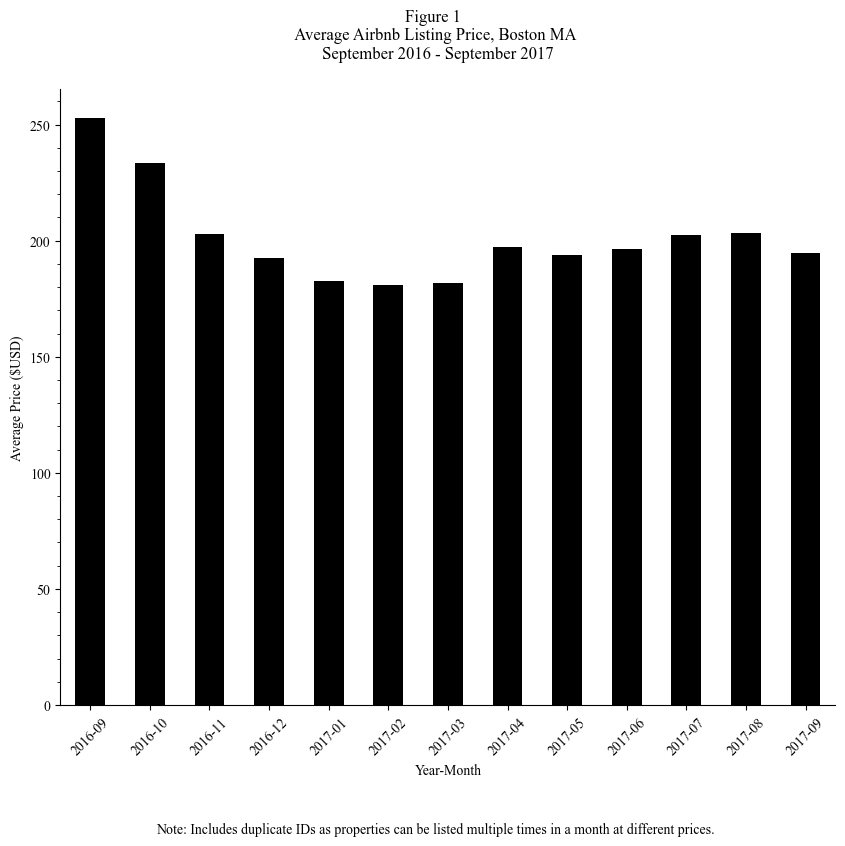

In [331]:
#Calculate the average listing price per month

#Calculate mean price per year-month
avg_list_price = CalLisCrime.groupby("year_month")["price"] \
                            .mean().reset_index()

#Convert "year_month" column to string
avg_list_price["year_month"] = avg_list_price["year_month"].astype(str)

#Create the scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
avg_list_price.plot(x="year_month", y="price", kind="bar", ax=ax, 
                    legend=False, color="black")

#Cleaning

#Remove right and top spines
ax.spines["right"].set_visible(False)   
ax.spines["top"].set_visible(False)

#Create title
fig.suptitle("Figure 1 \n Average Airbnb Listing Price, \
Boston MA \n September 2016 - September 2017")

#Set x label
ax.set_xlabel("Year-Month")

#Rotate x labels
plt.xticks(rotation=45)

#Set y label
ax.set_ylabel("Average Price ($USD)")

#Set y ticks to incriments of 50 for major ticks, 
#and set minor ticks to incriments of 10
ax.set_yticks(np.arange(0, 300, 50))  
ax.yaxis.set_minor_locator(mtick.MultipleLocator(10))  

#Create note
plt.figtext(0.5, -0.05, "Note: Includes duplicate IDs as properties can \
be listed multiple times in a month at different prices.", 
            ha="center", fontsize=10)

plt.show()

Figure 1 shows the monthly average Airbnb listing price in Boston over my period of interest.

I visualized this because it is necessary to see if the average listing price increased during the month of the Boston Marathon. The jump in average price in April 2017 supports my hypothesis. 

## Scatter Plot of Daily Average Airbnb Listing Price 

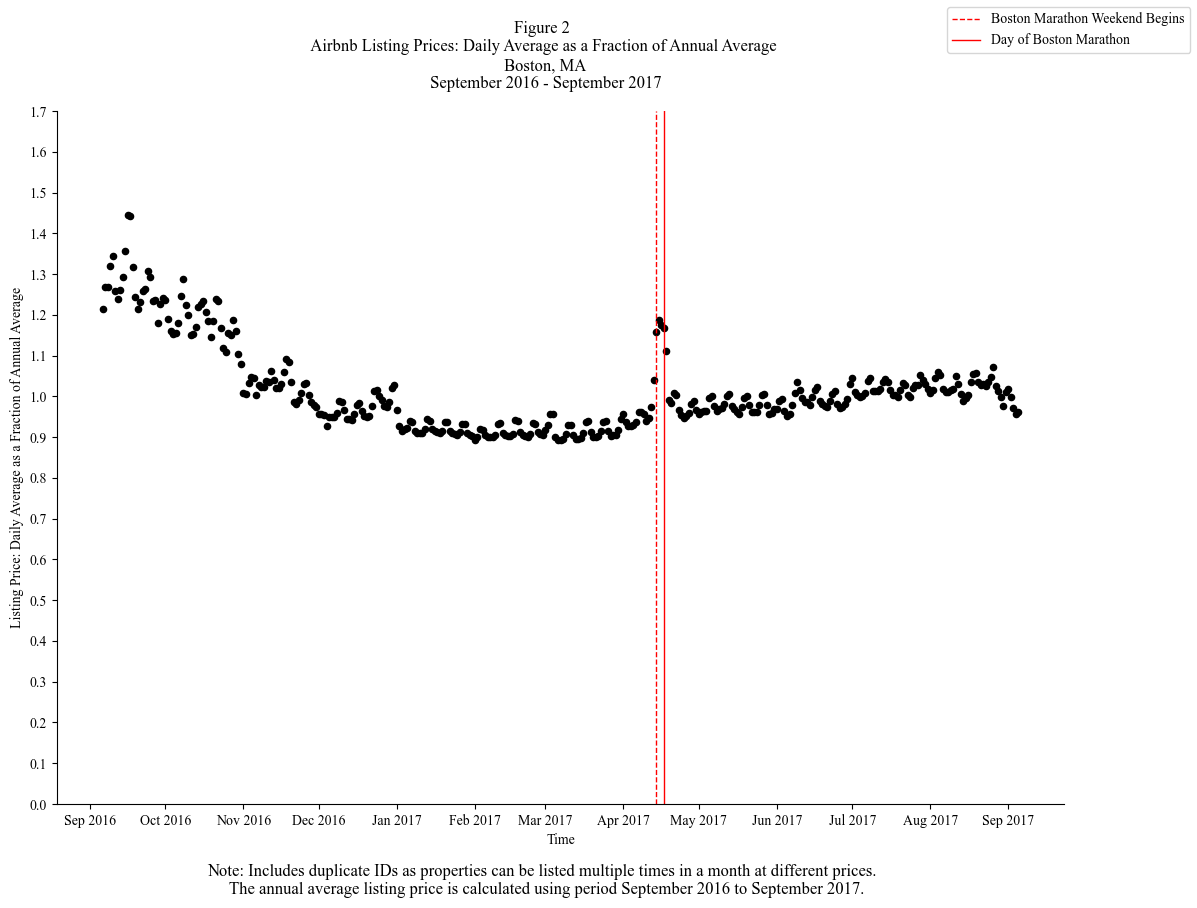

In [332]:
#Create temp dataset of average listing price per day
temp = CalLisCrime.groupby("date")["price"].mean().reset_index()

#Calculate average price over the whole study period
avg_price_year = calendar["price"].mean()

#Create column in temp for average daily price as a fraction of average annual price
temp["price fraction"] = temp["price"] / avg_price_year

#Configure figure and axes
fig, ax = plt.subplots(figsize=(13, 9))

#Create line plot for average price per day
temp.plot(x="date", y="price fraction", ax=ax, kind="scatter", legend=True, color="black")

#Create vertical lines indicating the day the Boston Marathon weekend begins and the day of the Boston Marathon
ax.axvline(x=pd.to_datetime("2017-04-14"), color="red", linestyle="--", linewidth=1, 
           label="Boston Marathon Weekend Begins")
ax.axvline(x=pd.to_datetime("2017-04-17"), color="red", linestyle="-", linewidth=1, 
           label="Day of Boston Marathon")

#Cleaning

#Remove right and top spines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

#Create y label
ax.set_ylabel("Listing Price: Daily Average as a Fraction of Annual Average")

#Set y ticks
ax.set_yticks(np.arange(0, 1.8, 0.1))
ax.yaxis.set_minor_locator(mtick.MultipleLocator(0.1))

#Create x label
ax.set_xlabel("Time")

#Label every month on x-axis
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter("%b %Y"))

#Create title
fig.suptitle("Figure 2 \n Airbnb Listing Prices: \
Daily Average as a Fraction of Annual Average \n \
Boston, MA \n September 2016 - September 2017")

#Place legend in upper right corner
fig.legend(loc="upper right")

plt.figtext(0.5, 0.01, "Note: Includes duplicate IDs as properties can be \
listed multiple times in a month at different prices. \n The annual average \
listing price is calculated using period September 2016 to September 2017.", \
ha="center", fontsize=12)

plt.show()


## Density Histograms of Airbnb Listing Prices by Time

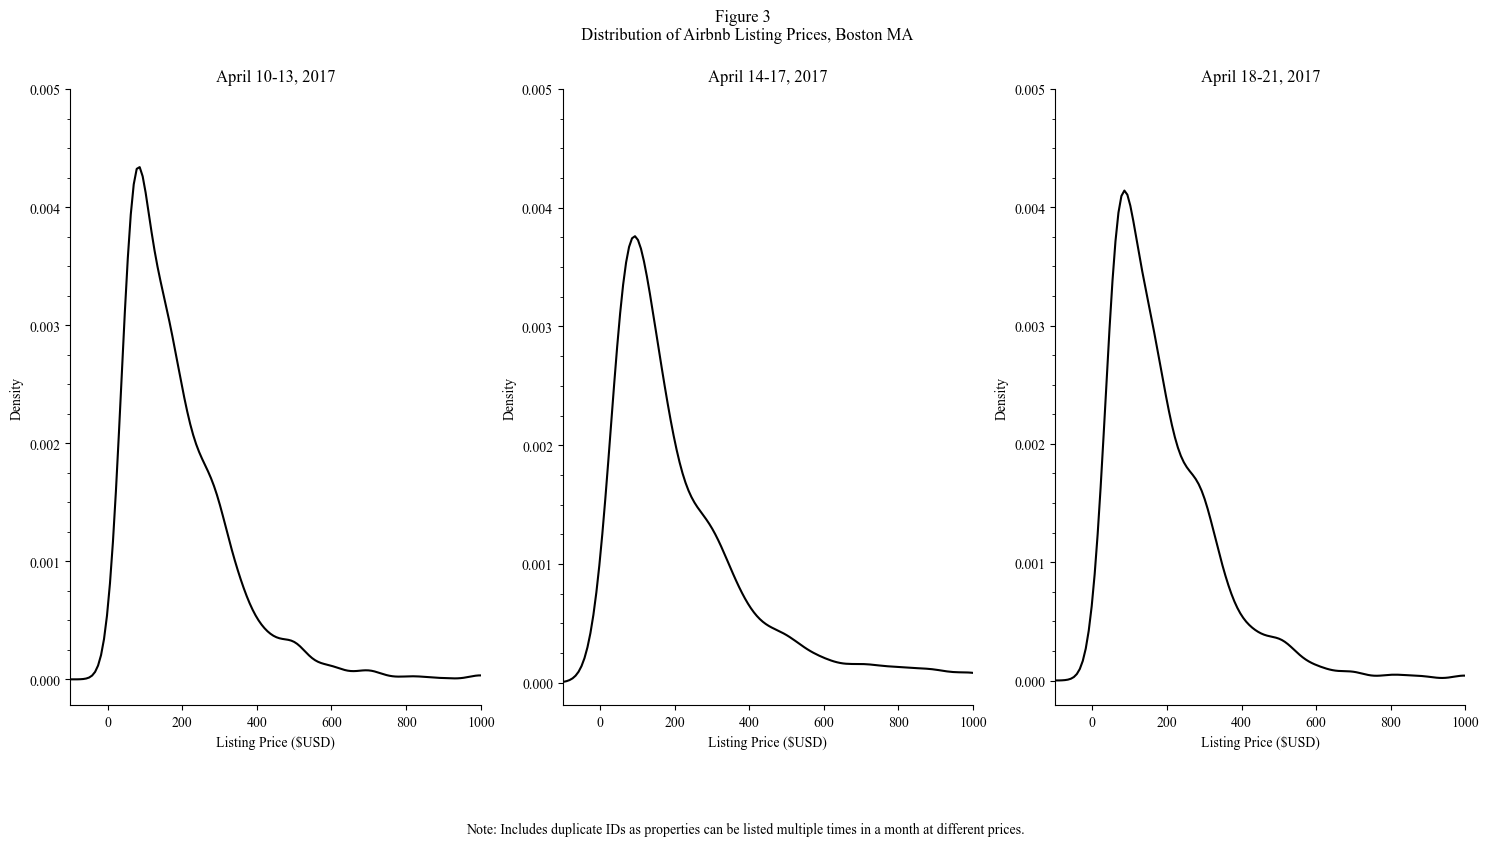

In [333]:
#Create temp datasets for April 10-13, 2017, April 14-17, 2017, and April 18-21, 2017
april10_13 = CalLisCrime[(CalLisCrime["date"] >= "2017-04-10") &
                            (CalLisCrime["date"] <= "2017-04-13")]
april14_17 = CalLisCrime[(CalLisCrime["date"] >= "2017-04-14") &
                            (CalLisCrime["date"] <= "2017-04-17")]
april18_21 = CalLisCrime[(CalLisCrime["date"] >= "2017-04-18") &
                            (CalLisCrime["date"] <= "2017-04-21")]

#Configure figure and axes, there are 3 axes and 1 figure
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

#Create April 10-13 histogram at axes[0]
april10_13.plot.density(y="price", ax=axes[0], legend=False, xlim=(-100, 1000), 
                   color="black") 

#Cleaning
#Remove right and top spines
axes[0].spines["right"].set_visible(False)   
axes[0].spines["top"].set_visible(False)

#Create title
axes[0].set_title("April 10-13, 2017")

#Create x label
axes[0].set_xlabel("Listing Price ($USD)")

#Set y ticks 
axes[0].set_yticks(np.arange(0, 0.0051, 0.001))  
axes[0].yaxis.set_minor_locator(mtick.MultipleLocator(0.00025)) 

#Create April 14-17 histogram at axes[1]
april14_17.plot.density(y="price", ax=axes[1], legend=False, xlim=(-100, 1000), 
                   color = "black") 

#Cleaning
axes[1].spines["right"].set_visible(False)   
axes[1].spines["top"].set_visible(False)

axes[1].set_title("April 14-17, 2017")

axes[1].set_xlabel("Listing Price ($USD)")

axes[1].set_yticks(np.arange(0, 0.0051, 0.001))  
axes[1].yaxis.set_minor_locator(mtick.MultipleLocator(0.00025)) 

#Create April 18-21 histogram at axes[1]
april18_21.plot.density(y="price", ax=axes[2], legend=False, xlim=(-100, 1000), 
                   color = "black") 

#Cleaning
axes[2].spines["right"].set_visible(False)   
axes[2].spines["top"].set_visible(False)

axes[2].set_title("April 18-21, 2017")

axes[2].set_xlabel("Listing Price ($USD)")

axes[2].set_yticks(np.arange(0, 0.0051, 0.001))  
axes[2].yaxis.set_minor_locator(mtick.MultipleLocator(0.00025)) 

#Create title
fig.suptitle("Figure 3 \n Distribution of Airbnb Listing Prices, Boston MA")

#Create note
plt.figtext(0.5, -0.05, "Note: Includes duplicate IDs as properties can \
be listed multiple times in a month at different prices.", 
            ha="center", fontsize=10)
plt.show()

Figure 2 presents the distribution of Boston Airbnb listing prices for March, April, and May 2017.

I visualized this distribution to check for anomalies in my outcome variable that may distort my future analysis. For instance, there are listing prices around $4000. From this, I may drop the outliers or do a log transformation on the price variable.

I also want to check if there is a significant change in the distribution of prices due to the increased demand brought about by the marathon. However, my figure shows that the distribution is stable, thus necessitating a visualization of the price distributions at the neighbourhood level.  

## Box Plots of Airbnb Listing Prices by Neighbourhood and Time

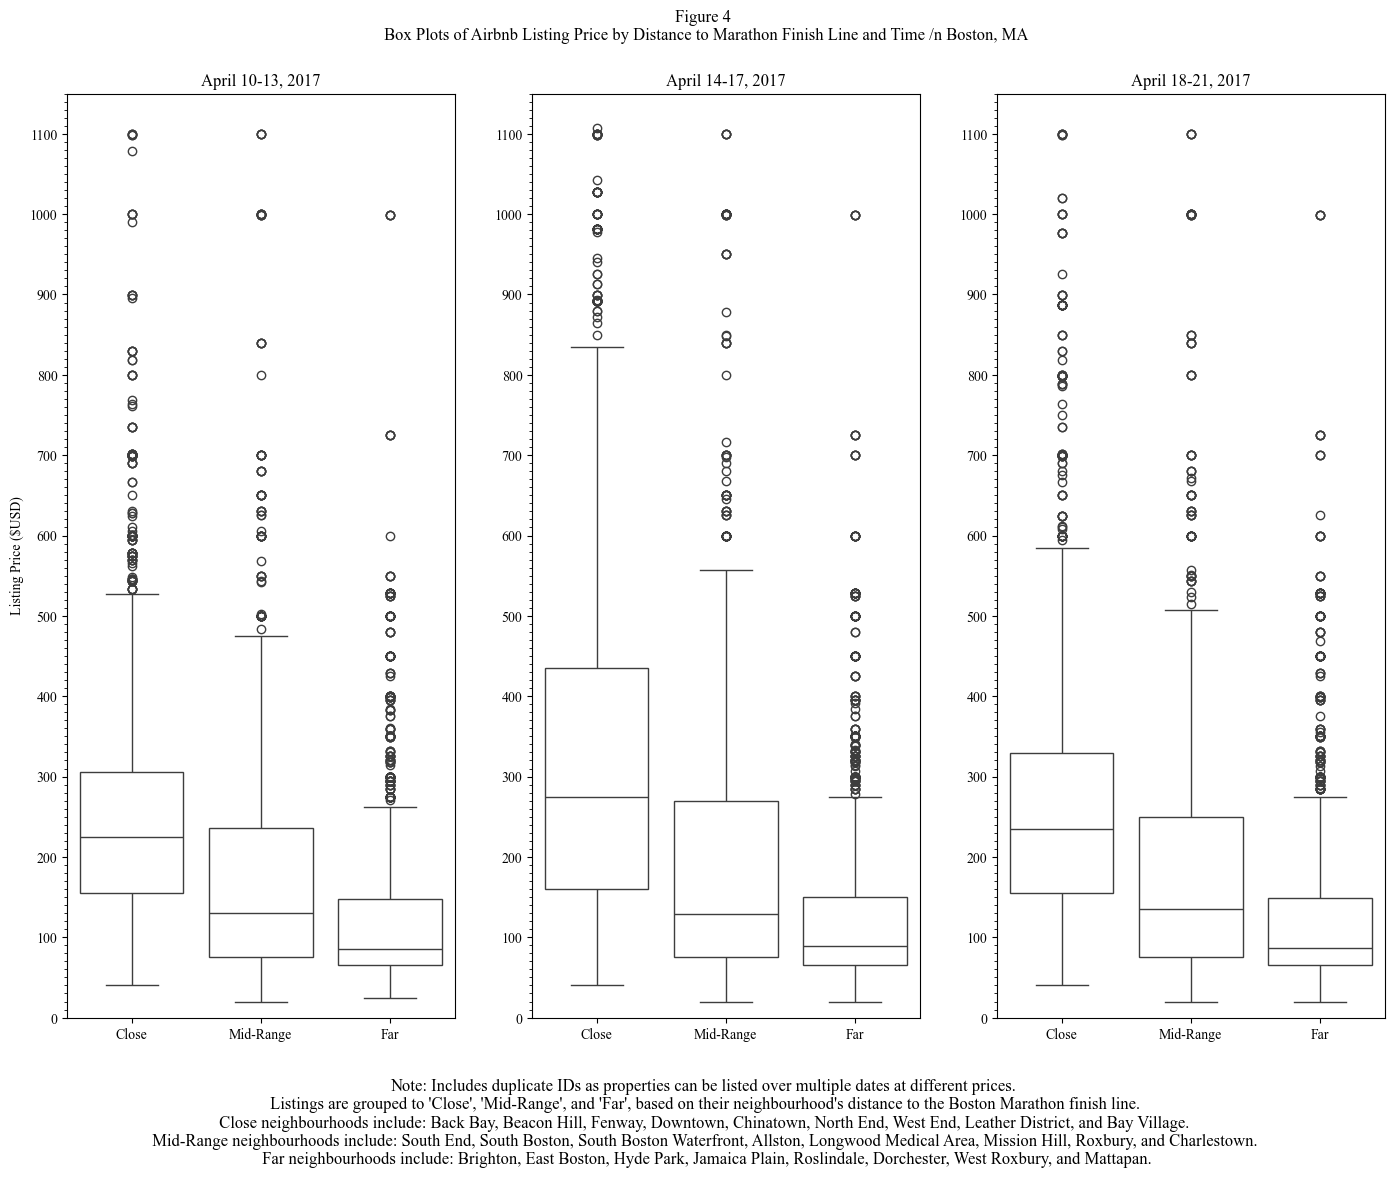

In [ ]:
#Idea sourced from: 
#https://www.kaggle.com/code/kostyabahshetsyan/boston-airbnb-visualization

#Create 3 lists for 'close', 'mid-range', and 'far' neighbourhoods
close = ["Back Bay", "Beacon Hill", "Fenway", "Downtown", "South End",
         "Chinatown", "North End", "West End", "Leather District", "Bay Village"]
mid_range = ["South Boston", "South Boston Waterfront",
             "Allston", "Longwood Medical Area", "Mission Hill",
             "Roxbury", "Charlestown"]
far = ["Brighton", "East Boston", "Hyde Park", "Jamaica Plain",
       "Roslindale", "Dorchester", "West Roxbury", "Mattapan"]

categories = ["close", "mid-range", "far"]

#Create filtered datasets for April 10-13, 2017, April 14-17, 2017, and April 18-21, 2017
april10_13 = CalLisCrime[(CalLisCrime["date"] >= "2017-04-10") &
                            (CalLisCrime["date"] <= "2017-04-13")]
april14_17 = CalLisCrime[(CalLisCrime["date"] >= "2017-04-14") &
                            (CalLisCrime["date"] <= "2017-04-17")]
april18_21 = CalLisCrime[(CalLisCrime["date"] >= "2017-04-18") &
                            (CalLisCrime["date"] <= "2017-04-21")]

#Configure figure and axes, there are 3 axes and 1 figure
fig, axes = plt.subplots(1, 3, figsize = (17, 12))

date = [april10_13, april14_17, april18_21]
date_str = ["April 10-13, 2017", "April 14-17, 2017", "April 18-21, 2017"]

index1 = 0
index2 = 0

for date in date:

       #Create dataset of April 10-13 by close, mid-range, and far neighbourhoods
       date_close = date[date["neighbourhood_cleansed"].isin(close)]
       date_mid_range = date[date["neighbourhood_cleansed"].isin(mid_range)]
       date_far = date[date["neighbourhood_cleansed"].isin(far)]

       #Keep only price column and rename price column to pice_close, price_mid_range, price_far
       date_close = date_close[["price"]].rename(columns={"price": "Close"})
       date_mid_range = date_mid_range[["price"]].rename(columns={"price": "Mid-Range"})
       date_far = date_far[["price"]].rename(columns={"price": "Far"})

       #Merge datasets 
       date_merged = pd.concat([date_close, date_mid_range, date_far], axis=1)

       sns.boxplot(data=date_merged, 
       ax=axes[index1], boxprops=dict(facecolor="none"))
       
       axes[index1].set_title(date_str[index2])

       axes[0].set_ylabel("Listing Price ($USD)")

       axes[index1].set_yticks(np.arange(0, 1151, 100)) 
       axes[index1].yaxis.set_minor_locator(mtick.MultipleLocator(10)) 

       axes[index1].set_ylim(0, 1150)
       
       index1 += 1
       index2 += 1

#Create title
fig.suptitle("Figure 4 \n Box Plots of Airbnb Listing Price by Distance to Marathon " \
              "Finish Line and Time /n Boston, MA", fontsize=12, y=0.95)

plt.figtext(0.5, -0.01, "Note: Includes duplicate IDs as properties can be \
listed over multiple dates at different prices. \n Listings are grouped to 'Close', \
'Mid-Range', and 'Far', based on their neighbourhood's distance to the Boston "
"Marathon finish line. \n \
Close neighbourhoods include: Back Bay, Beacon Hill, Fenway, Downtown, \
Chinatown, North End, West End, Leather District, and Bay Village. \n Mid-Range \
neighbourhoods include: South End, South Boston, South Boston Waterfront, \
Allston, Longwood Medical Area, Mission Hill, Roxbury, and Charlestown. \n \
Far neighbourhoods include: Brighton, East Boston, Hyde Park, Jamaica Plain, \
Roslindale, Dorchester, West Roxbury, and Mattapan.", 
ha="center", fontsize=12, wrap=True)

plt.show()


Figure 3 presents box plots of Airbnb listing prices for each neighbourhood in Boston for March, April, and May 2017. 

This figure allows me to assess if prices respond to the April marathon only in certain neighbourhoods. This then helps me determine my treatment and control groups. After assessing a map of Boston neighbourhoods and the marathon route, I find that some neighbourhoods closest to the marathon include Back Bay, Beacon Hill, Fenway, and Allston, while some farthest and less likely to be affected include West Roxbury, and Roslindale (Brady 2017 and City of Boston 2009). 

This figure shows that the listing prices in some potential treatment neighbourhoods increase in April. For instance, Back Bay has a higher mean in April. However, Allston stays relatively consistent. Yet, the potential control neighbourhoods also stay relatively consistent. Therefore, Figure 3 somewhat supports my research design, however more neighbourhood level data needs to be assessed.

## Line Plots of Average Listing Price for Potential Treatment and Control Neighbourhoods Over Time

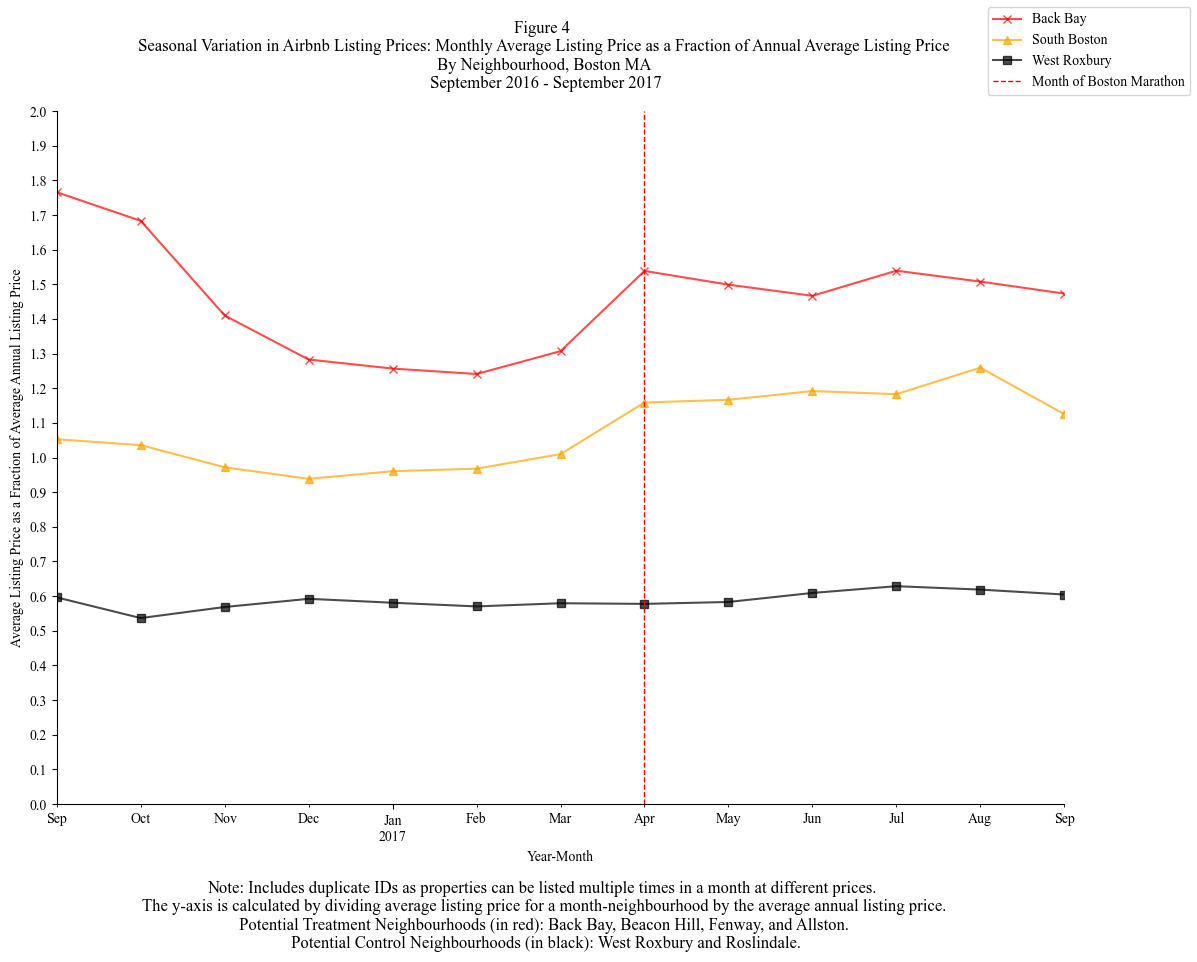

In [335]:
#Group CalLisCrime by "neighbourhood_cleansed" and "year_month" and calculate
#average price
nei_price1 = CalLisCrime.groupby(["neighbourhood_cleansed", 
                                  "year_month"])["price"] \
                        .mean().reset_index()

#Calculate average price over the whole study period
avg_price_year = calendar["price"].mean()

#Create column in neigh_price1 called Price Standardized
nei_price1["price fraction"] = nei_price1["price"] / avg_price_year

#Create table of average price by neighbourhood for each month
nei_price1_pivot = nei_price1.pivot(index="year_month", 
                                    columns="neighbourhood_cleansed",
                                    values="price fraction")

#Configure figure and axes
fig, ax = plt.subplots(figsize=(13, 9))

#Create lines for average price by selected neighbourhood per month
nei_price1_pivot["Back Bay"].plot(ax=ax, alpha=0.7, legend=False, 
                                   marker="x", color="red")

nei_price1_pivot["South Boston"].plot(ax=ax, alpha=0.7, legend=False, 
                                      marker="^", color="orange")

nei_price1_pivot["West Roxbury"].plot(ax=ax, alpha=0.7, legend=False, 
                                       marker="s", color="black")

#Create vertical line indicating the month of the Boston Marathon
ax.axvline(x="2017-04", color="red", linestyle="--", linewidth=1, 
           label="Month of Boston Marathon")

#Cleaning
#Remove right and top spines
ax.spines["right"].set_visible(False)   
ax.spines["top"].set_visible(False)

#Create y label
ax.set_ylabel("Average Listing Price as a Fraction of Average Annual Listing Price")

#Create x label
ax.set_xlabel("Year-Month")

#Create title
fig.suptitle("Figure 4 \n Seasonal Variation in Airbnb Listing Prices: \
Monthly Average Listing Price as a Fraction of Annual Average Listing Price \n \
By Neighbourhood, Boston MA \n September 2016 - September 2017")

#Set y ticks
ax.set_yticks(np.arange(0, 2.1, 0.1)) 
#ax.yaxis.set_minor_locator(mtick.MultipleLocator(0.5)) 

#Place legend in upper right corner
fig.legend(loc="upper right")

#Create note
plt.figtext(0.5, -0.05, "Note: Includes duplicate IDs as properties can be \
listed multiple times in a month at different prices. \n The y-axis is calculated \
by dividing average listing price for a month-neighbourhood by the average annual listing \
price. \n Potential Treatment Neighbourhoods (in red): Back Bay, Beacon Hill, Fenway, \
and Allston. \n Potential Control Neighbourhoods (in black): West Roxbury and Roslindale.", 
ha="center", fontsize=12)

plt.show()


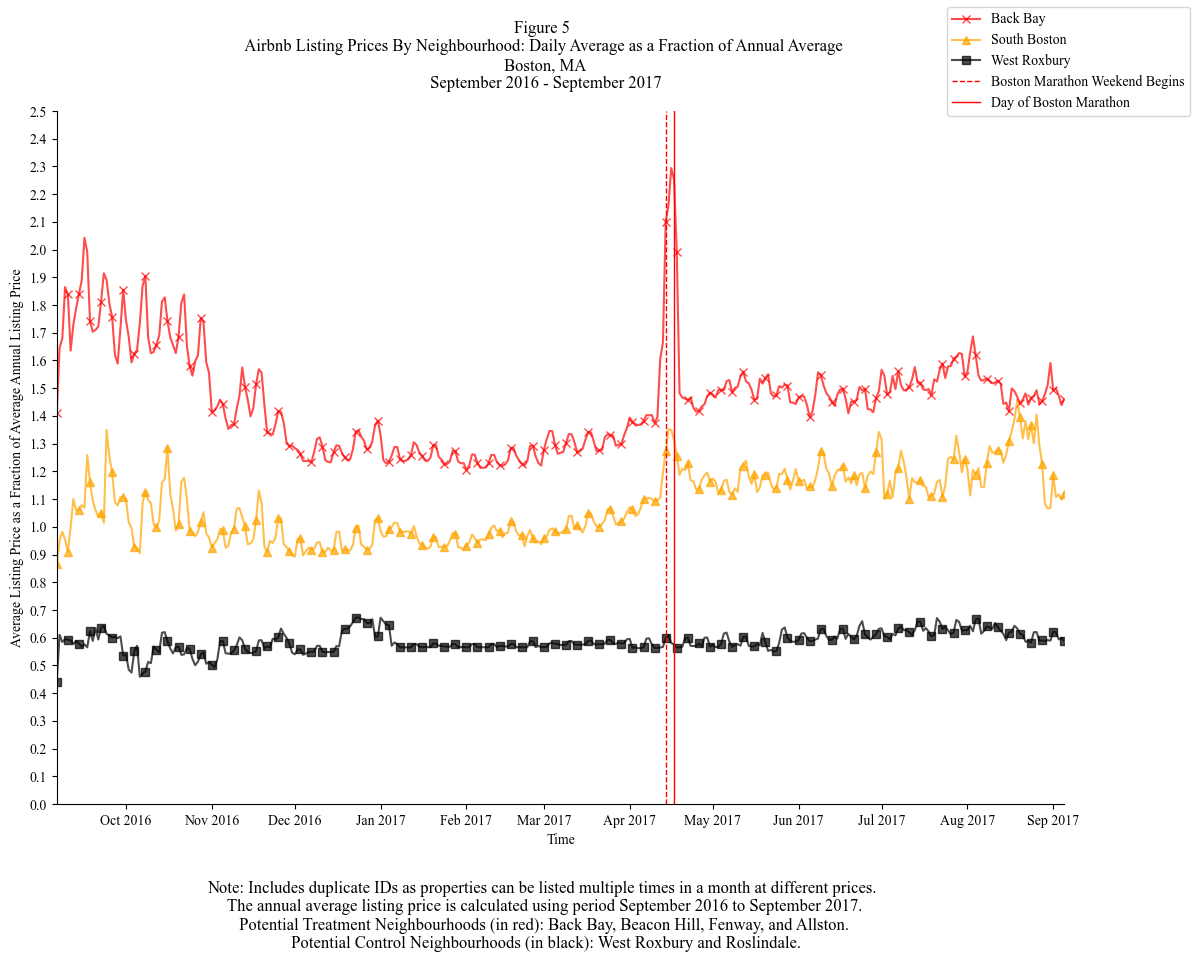

In [336]:
#Group CalLisCrime by "neighbourhood_cleansed" and "date" and calculate
#average price
neigh_price2 = CalLisCrime.groupby(["neighbourhood_cleansed", "date"]) \
                            ["price"].mean().reset_index()

#Calculate average price over the whole study period
avg_price_year = calendar["price"].mean()

#Create column in neigh_price2 called average price as a percent of average annual price
neigh_price2["price fraction"] = neigh_price2["price"] / avg_price_year

#Create table of average price by neighbourhood for each day
neigh_price2_pivot = neigh_price2.pivot(index="date", 
                                        columns="neighbourhood_cleansed",
                                        values="price fraction")

#Configure figure and axes
fig, ax = plt.subplots(figsize=(13, 9))

#Create lines for average price by selected neighbourhood per day
neigh_price2_pivot["Back Bay"].plot(ax=ax, alpha=0.7, legend=False, 
                                    marker="x", markevery=4, color="red")
neigh_price2_pivot["South Boston"].plot(ax=ax, alpha=0.7, legend=False, 
                                       marker="^", markevery=4, color="orange")
neigh_price2_pivot["West Roxbury"].plot(ax=ax, alpha=0.7, legend=False, 
                                    marker="s", markevery=4, color="black")


ax.axvline(x=pd.to_datetime("2017-04-14"), color="red", linestyle="--", linewidth=1, 
           label="Boston Marathon Weekend Begins")
ax.axvline(x=pd.to_datetime("2017-04-17"), color="red", linestyle="-", linewidth=1, 
           label="Day of Boston Marathon")

#Cleaning

#Remove right and top spines
ax.spines["right"].set_visible(False)   
ax.spines["top"].set_visible(False)

#Create y label
ax.set_ylabel("Average Listing Price as a Fraction of Average Annual Listing Price")

#Create x label
ax.set_xlabel("Time")

#Label x axis with month and year
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter("%b %Y"))
ax.xaxis.set_minor_locator(mticker.NullLocator())

#Create title
fig.suptitle("Figure 5 \n Airbnb Listing Prices By Neighbourhood: \
Daily Average as a Fraction of Annual Average \
\n Boston, MA \n September 2016 - September 2017")

#Set y ticks
ax.set_yticks(np.arange(0, 2.51, 0.1)) 
ax.yaxis.set_minor_locator(mtick.MultipleLocator(0.1)) 

#Place legend in upper right corner
fig.legend(loc="upper right")

plt.figtext(0.5, -0.05, "Note: Includes duplicate IDs as properties can be \
listed multiple times in a month at different prices. \n The annual average \
listing price is calculated using period September 2016 to September 2017. \
\n Potential Treatment Neighbourhoods (in red): Back Bay, Beacon Hill, Fenway, \
and Allston. \n Potential Control Neighbourhoods (in black): West Roxbury and Roslindale.", 
ha="center", fontsize=12)

plt.show()

Figures 4 and 5 present monthly and daily average Airbnb listing prices respectively for the beforementioned potential treatment and control neighbourhoods. 

Figure 5 supports my hypothesis and research design as Back Bay, Beacon Hill, and Fenway’s average listing prices jump around the date of the marathon while West Roxbury’s does not. Roslindale has a relatively smaller increase in price during the marathon and Allston remains as a potential treatment neighbourhood with stable prices during the marathon.

# Project 2

# 5. Maps

## 5.1: Boston Airbnb Listings: Percent Change in Price Before & During the Boston Marathon

In [337]:
#Create a temp dataset which only includes a day the week before the marathon and
#the day of the marathon

pre_marathon = CalLisCrime[CalLisCrime["date"] == "2017-04-10"][["id", "price"]]
during_marathon = CalLisCrime[CalLisCrime["date"] == "2017-04-17"][["id", "price"]]

# Rename columns for clarity
pre_marathon.rename(columns={"price": "pre_marathon_price"}, inplace=True)
during_marathon.rename(columns={"price": "during_marathon_price"}, inplace=True)

# Merge the two dataframes on property ID
price_comparison = pre_marathon.merge(during_marathon, on="id", how="inner")

#Drop duplicate listings
price_comparison.drop_duplicates(subset=["id"], keep="first", inplace=True)

#Drop properties with NaN values
price_comparison.dropna(inplace=True)

#Calculate the difference in price
price_comparison["Difference"] = price_comparison["during_marathon_price"] \
      - price_comparison["pre_marathon_price"]

#Create column for percent change in price
price_comparison["Percent Change"] = (price_comparison["Difference"] \
                                       / price_comparison["pre_marathon_price"]) \
                                     * 100

#Drop outliers (ie. if % change > 300%)
price_comparison = price_comparison[price_comparison["Percent Change"] <= 300]

price_comparison.set_index("id", inplace=True)

In [338]:
CalLisCrime["property_coords"] = list(zip(
    CalLisCrime.longitude, CalLisCrime.latitude))

temp1 = CalLisCrime[(CalLisCrime["date"] == "2017-04-10") | \
                    (CalLisCrime["date"] == "2017-04-17")].copy()

temp1.drop_duplicates(subset=["id"], keep="last", inplace=True)

temp1 = temp1[["id", "property_coords"]]

temp1.set_index("id", inplace=True)

price_comparison = price_comparison.merge(temp1, on="id", how="inner")

#Drop if 0 in difference column
price_comparison1 = price_comparison[price_comparison["Difference"] != 0]



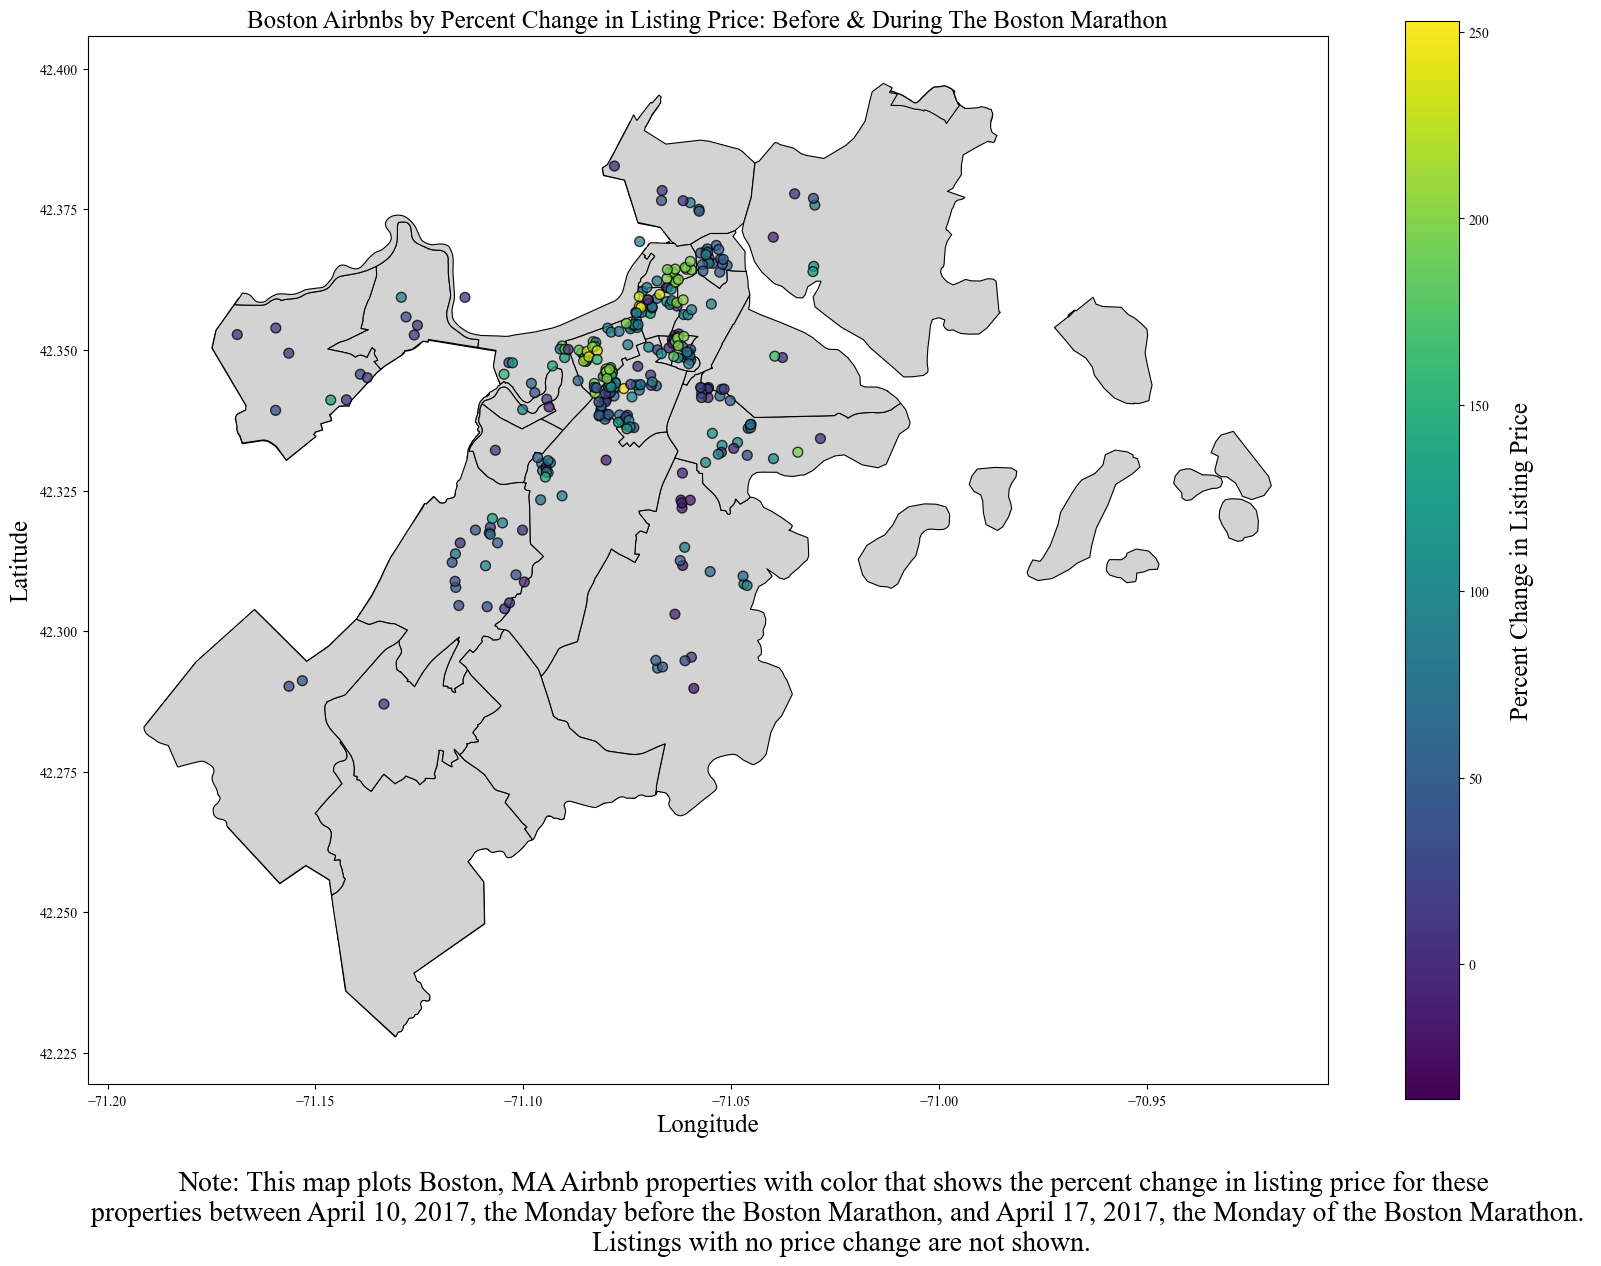

In [339]:
price_comparison1 = price_comparison1.copy()

price_comparison1["property_coords"] = price_comparison1[
    "property_coords"].apply(Point)

price_comparison_geo = gpd.GeoDataFrame(price_comparison1, \
                                        geometry="property_coords")

boston = gpd.read_file(r"C:\\Users\\eliea\\Desktop\\UofTYear3\\Term_2\\Eco225\\ECO225Project\\"
                               "city_of_boston_outline_boundary_water_excluded.json")

boston_neighbourhoods = gpd.read_file(r"C:\\Users\\eliea\\Desktop\\UofTYear3\\Term_2\\Eco225\\ECO225Project\\"
                               "boston_neighborhood_boundaries_approximated_by_2020_census_tracts.json")

price_comparison_geo.set_crs(boston.crs, inplace=True)

# Create the plot
fig, gax = plt.subplots(figsize=(20, 20))

boston.plot(ax=gax, color="lightgray", edgecolor="black")

boston_neighbourhoods.plot(ax=gax, edgecolor="black", linewidth=0.8,
                           color="lightgrey")

price_comparison_geo.plot(
    ax=gax,
    column="Percent Change",  
    cmap="viridis",  
    markersize=50,
    edgecolor="black",
    alpha=0.75,
    legend=True,
    legend_kwds={"label": "Percent Change in Listing Price", "shrink": 0.7}
)

cbar = gax.get_figure().get_axes()[1] 
cbar.set_ylabel("Percent Change in Listing Price", fontsize=18, labelpad=15)

gax.set_title("Boston Airbnbs by Percent Change in Listing Price: " \
               "Before & During The Boston Marathon", 
              fontsize=18)
gax.set_xlabel("Longitude", fontsize = 18)
gax.set_ylabel("Latitude", fontsize = 18)

#Add a note
plt.figtext(0.5, 0.15, "Note: This map plots Boston, MA Airbnb properties with color that " \
            "shows the percent change in listing price for these \n properties between April " \
            "10, 2017, the Monday before the Boston Marathon, and April 17, 2017, the " \
            "Monday of the Boston Marathon. \n Listings with no price change " \
            "are not shown.", ha="center", fontsize=20)

plt.show()

## 5.2: Boston Airbnbs: Average Change in Price by Neighbourhood

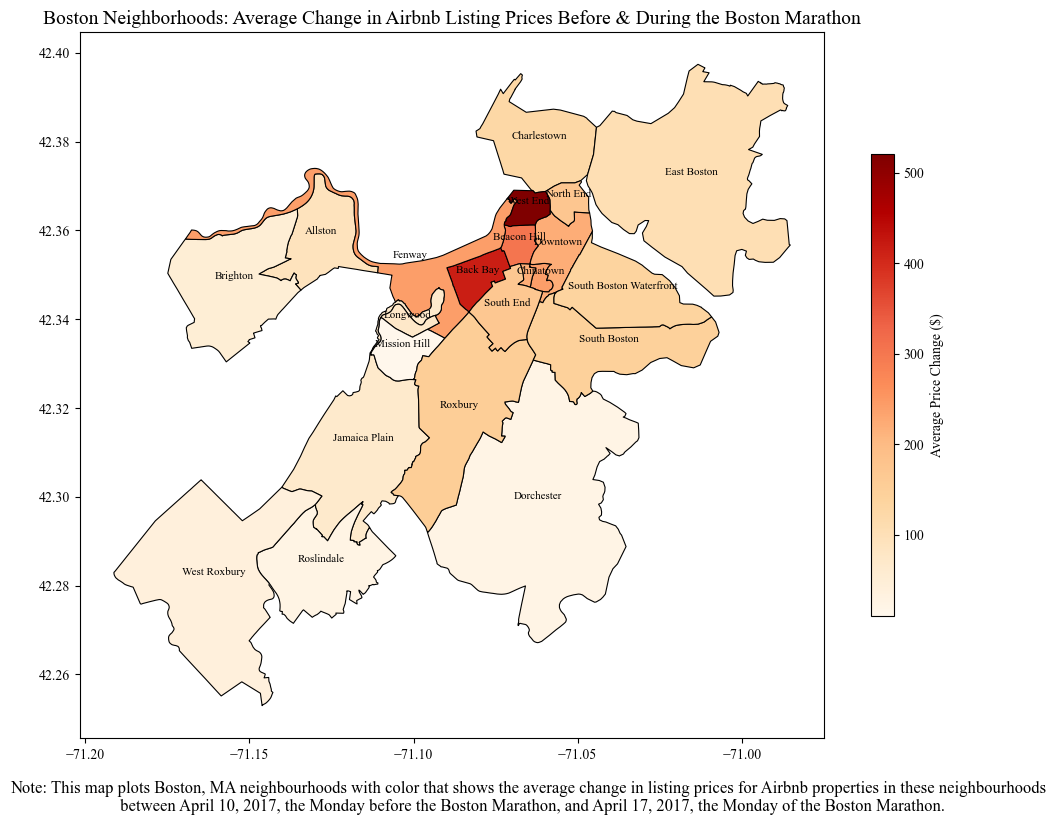

In [340]:
boston_neighbourhoods = gpd.read_file(r"C:\\Users\\eliea\\Desktop\\UofTYear3\\Term_2\\Eco225\\ECO225Project\\"
                               "boston_neighborhood_boundaries_approximated_by_2020_census_tracts.json")

price_comparison_geo = gpd.sjoin(price_comparison_geo, 
                                 boston_neighbourhoods, how="left", predicate="within")

neighborhood_price_change = price_comparison_geo.groupby(
    price_comparison_geo["neighborhood"])["Difference"].mean().reset_index()

boston_neighborhoods = boston_neighbourhoods.merge(
    neighborhood_price_change, on="neighborhood", how="left")

boston_neighborhoods = boston_neighborhoods.to_crs(epsg=26986) 
boston_neighborhoods["centroid"] = boston_neighborhoods.geometry.centroid  
boston_neighborhoods["centroid"] = boston_neighborhoods["centroid"].to_crs(
    epsg=4326)
boston_neighborhoods = boston_neighborhoods.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(12, 12))

boston_neighborhoods.plot(
    ax=ax,
    column="Difference",
    cmap="OrRd",
    edgecolor="black",
    linewidth=0.8,
    legend=True,
    legend_kwds={"label": "Average Price Change ($)", "shrink": 0.5}
)

valid_neighborhoods = neighborhood_price_change["neighborhood"].unique()

for idx, row in boston_neighborhoods.iterrows():
    if row["neighborhood"] in valid_neighborhoods:  
        plt.annotate(
            text=row["neighborhood"],
            xy=(row["centroid"].x, row["centroid"].y),
            xytext=(0, 3),  
            textcoords="offset points",
            fontsize=8,
            color="black",
            ha="center"
        )

gax.set_xlabel("Longitude", fontsize = 18)
gax.set_ylabel("Latitude", fontsize = 18)

# Labels and title
ax.set_title(
"Boston Neighborhoods: Average Change in Airbnb Listing Prices Before & During the Boston Marathon", 
fontsize=14)


plt.figtext(0.5, 0.14, "Note: This map plots Boston, MA neighbourhoods with color that " \
            "shows the average change in listing prices for Airbnb properties in these neighbourhoods " \
            "\n between April 10, 2017, the Monday before the Boston Marathon, and April 17, "
            "2017, the Monday of the Boston Marathon.", ha="center", fontsize=12)

plt.show()


# Boston Airbnb Superhosts

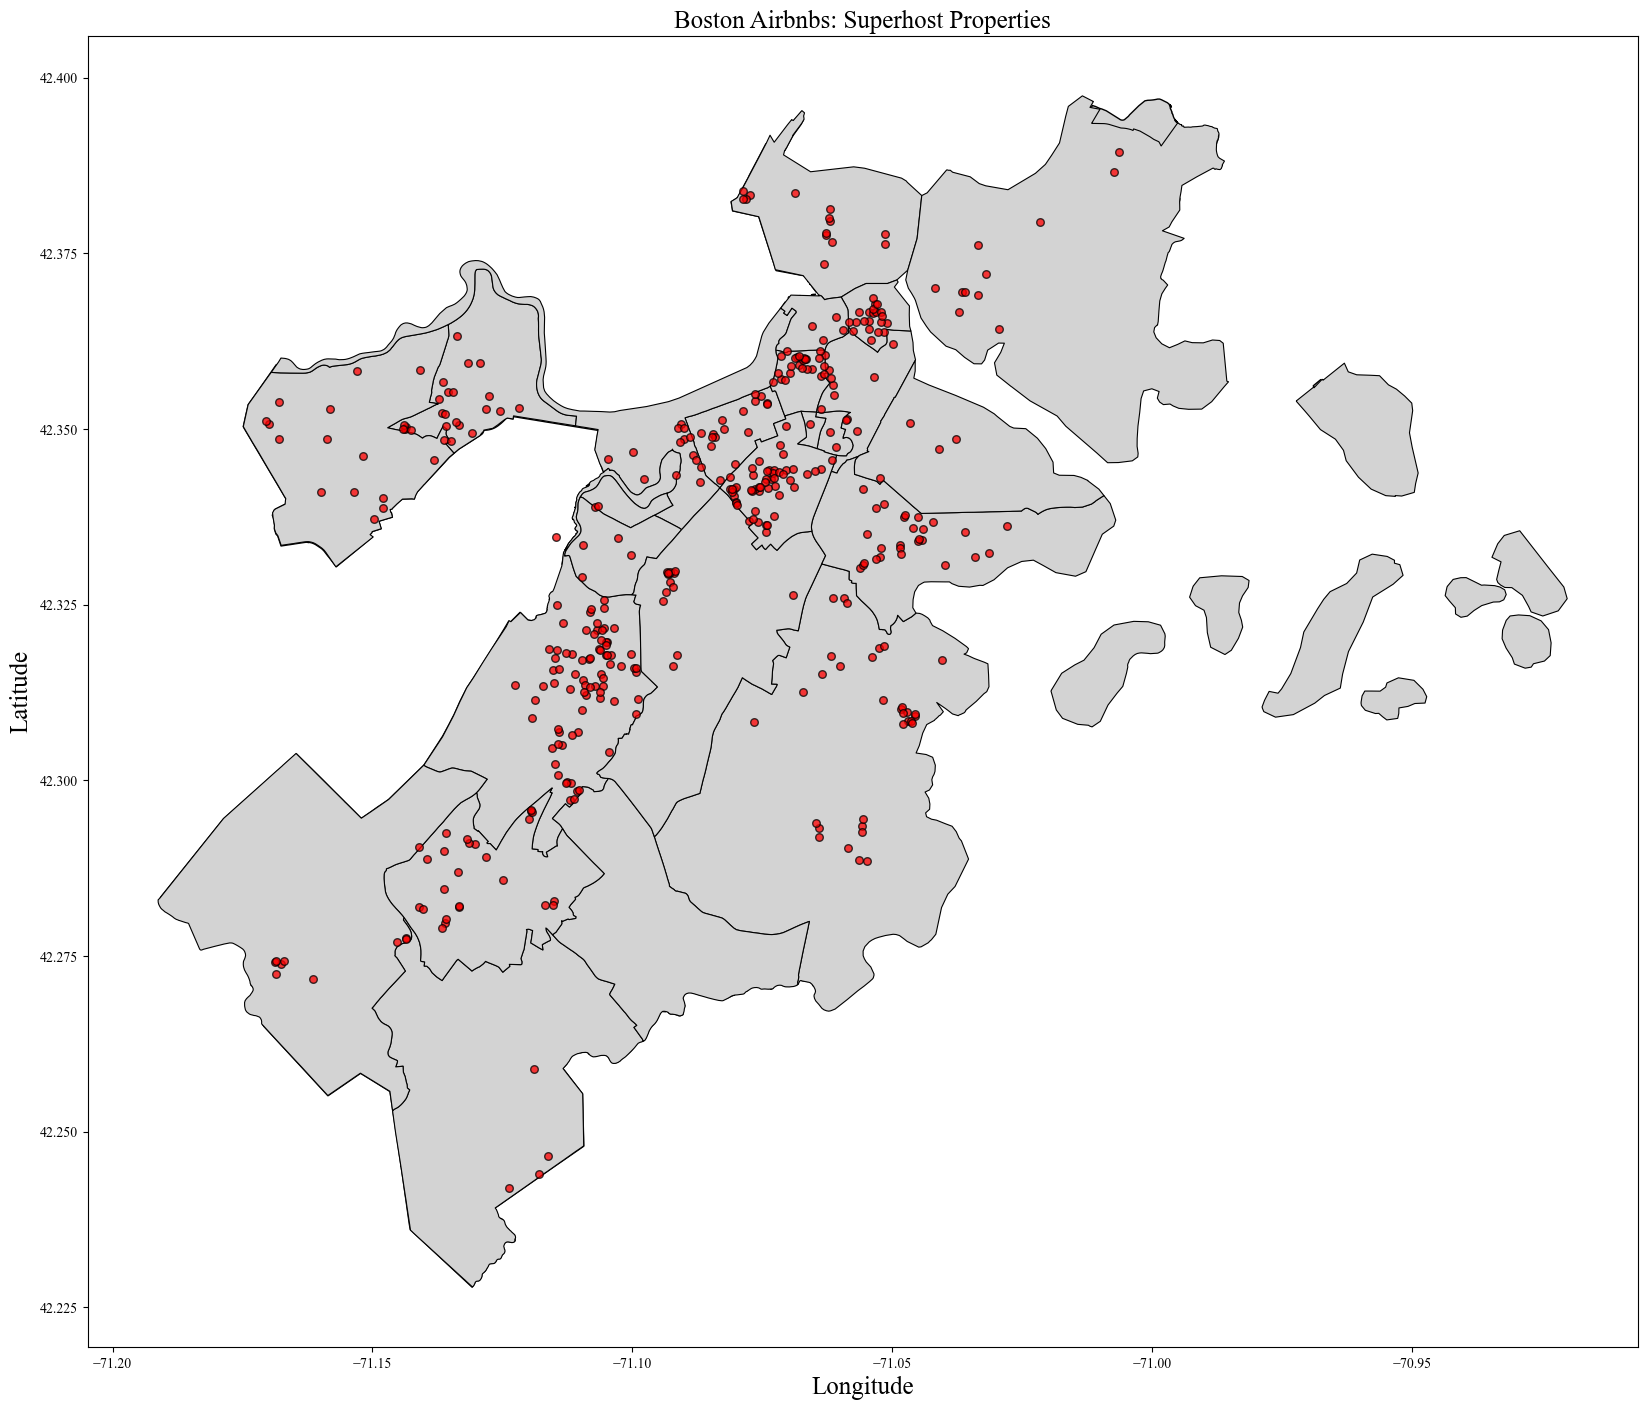

In [461]:
#Plot all superhost properties in Boston

map3 = CalLisCrime.copy()

#Remove duplicate ids
map3.drop_duplicates(subset=["id"], keep="first", inplace=True)

map3["property_coords"] = list(zip(map3.longitude, map3.latitude))
map3["property_coords"] = map3["property_coords"].apply(Point)

map3 = gpd.GeoDataFrame(map3, geometry="property_coords")

map3.set_crs(epsg=4326, inplace=True)

fig, ax = plt.subplots(figsize=(20, 20))

boston.plot(ax=ax, color="lightgray", edgecolor="black")

boston_neighbourhoods.plot(ax=ax, edgecolor="black", linewidth=0.8,
                            color="lightgrey")

map3[map3["Superhost"] == 1].plot(
    ax=ax,
    color="red",
    markersize=30,
    edgecolor="black",
    alpha=0.75
)

ax.set_title("Boston Airbnbs: Superhost Properties", fontsize=18)

ax.set_xlabel("Longitude", fontsize = 18)
ax.set_ylabel("Latitude", fontsize = 18)

plt.show()

## Map of Properties by Property Type

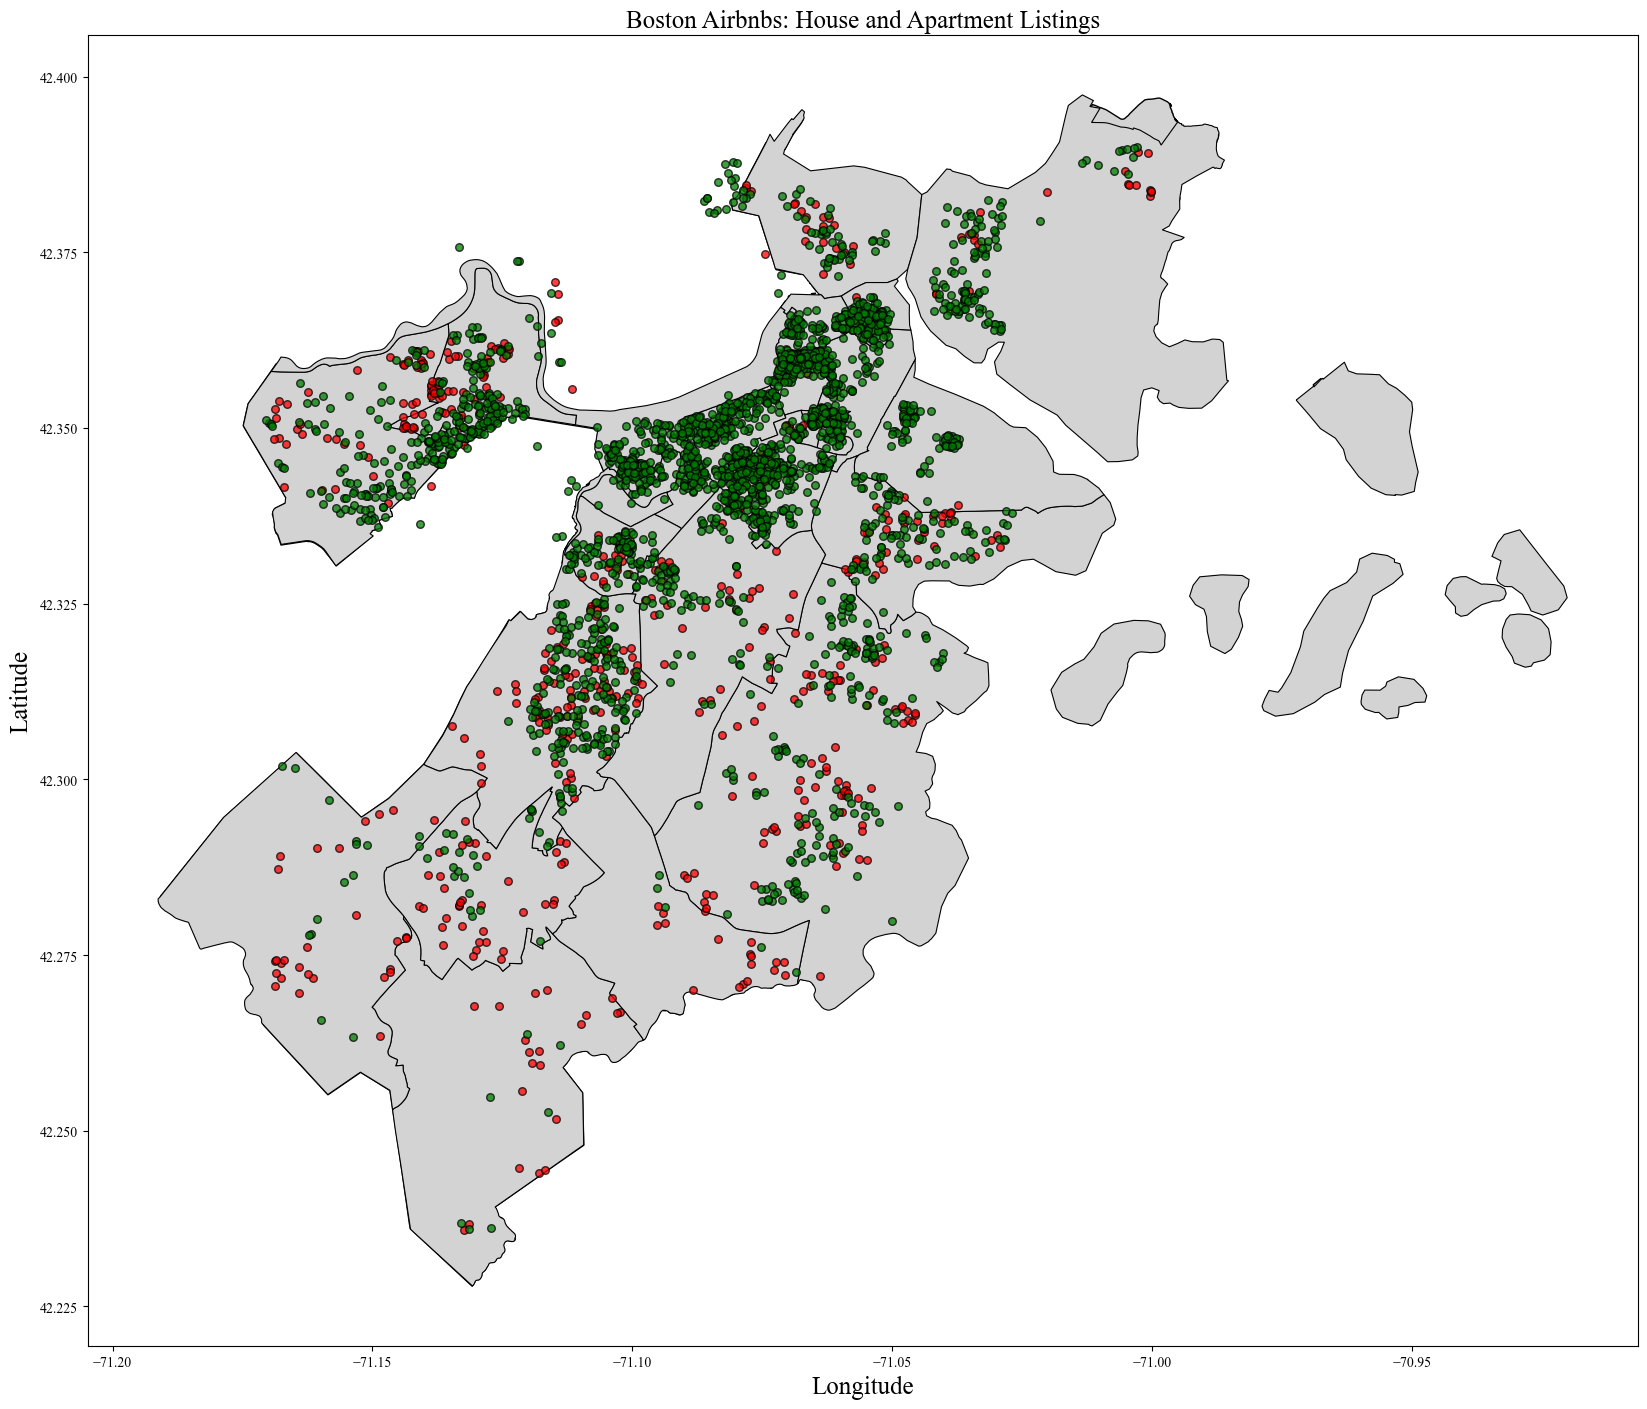

In [462]:
# Map Boston Airbnbs
# Only house or apartment listings
# House in red, apartment in green

map4 = CalLisCrime.copy()

#Remove duplicate ids
map4.drop_duplicates(subset=["id"], keep="first", inplace=True)

map4["property_coords"] = list(zip(map4.longitude, map4.latitude))
map4["property_coords"] = map4["property_coords"].apply(Point)

map4 = gpd.GeoDataFrame(map4, geometry="property_coords")

map4.set_crs(epsg=4326, inplace=True)

fig, ax = plt.subplots(figsize=(20, 20))

boston.plot(ax=ax, color="lightgray", edgecolor="black")

boston_neighbourhoods.plot(ax=ax, edgecolor="black", linewidth=0.8,
                            color="lightgrey")

map4[map4["property_type"] == "House"].plot(
    ax=ax,
    color="red",
    markersize=30,
    edgecolor="black",
    alpha=0.75
)

map4[map4["property_type"] == "Apartment"].plot(
    ax=ax,
    color="green",
    markersize=30,
    edgecolor="black",
    alpha=0.75
)

ax.set_title("Boston Airbnbs: House and Apartment Listings", fontsize=18)

ax.set_xlabel("Longitude", fontsize = 18)
ax.set_ylabel("Latitude", fontsize = 18)

plt.show()

# 6. Difference in Differences Regression

## Correlation Matrix

I first create a correlation matrix to determine which covariates are related to listing price.

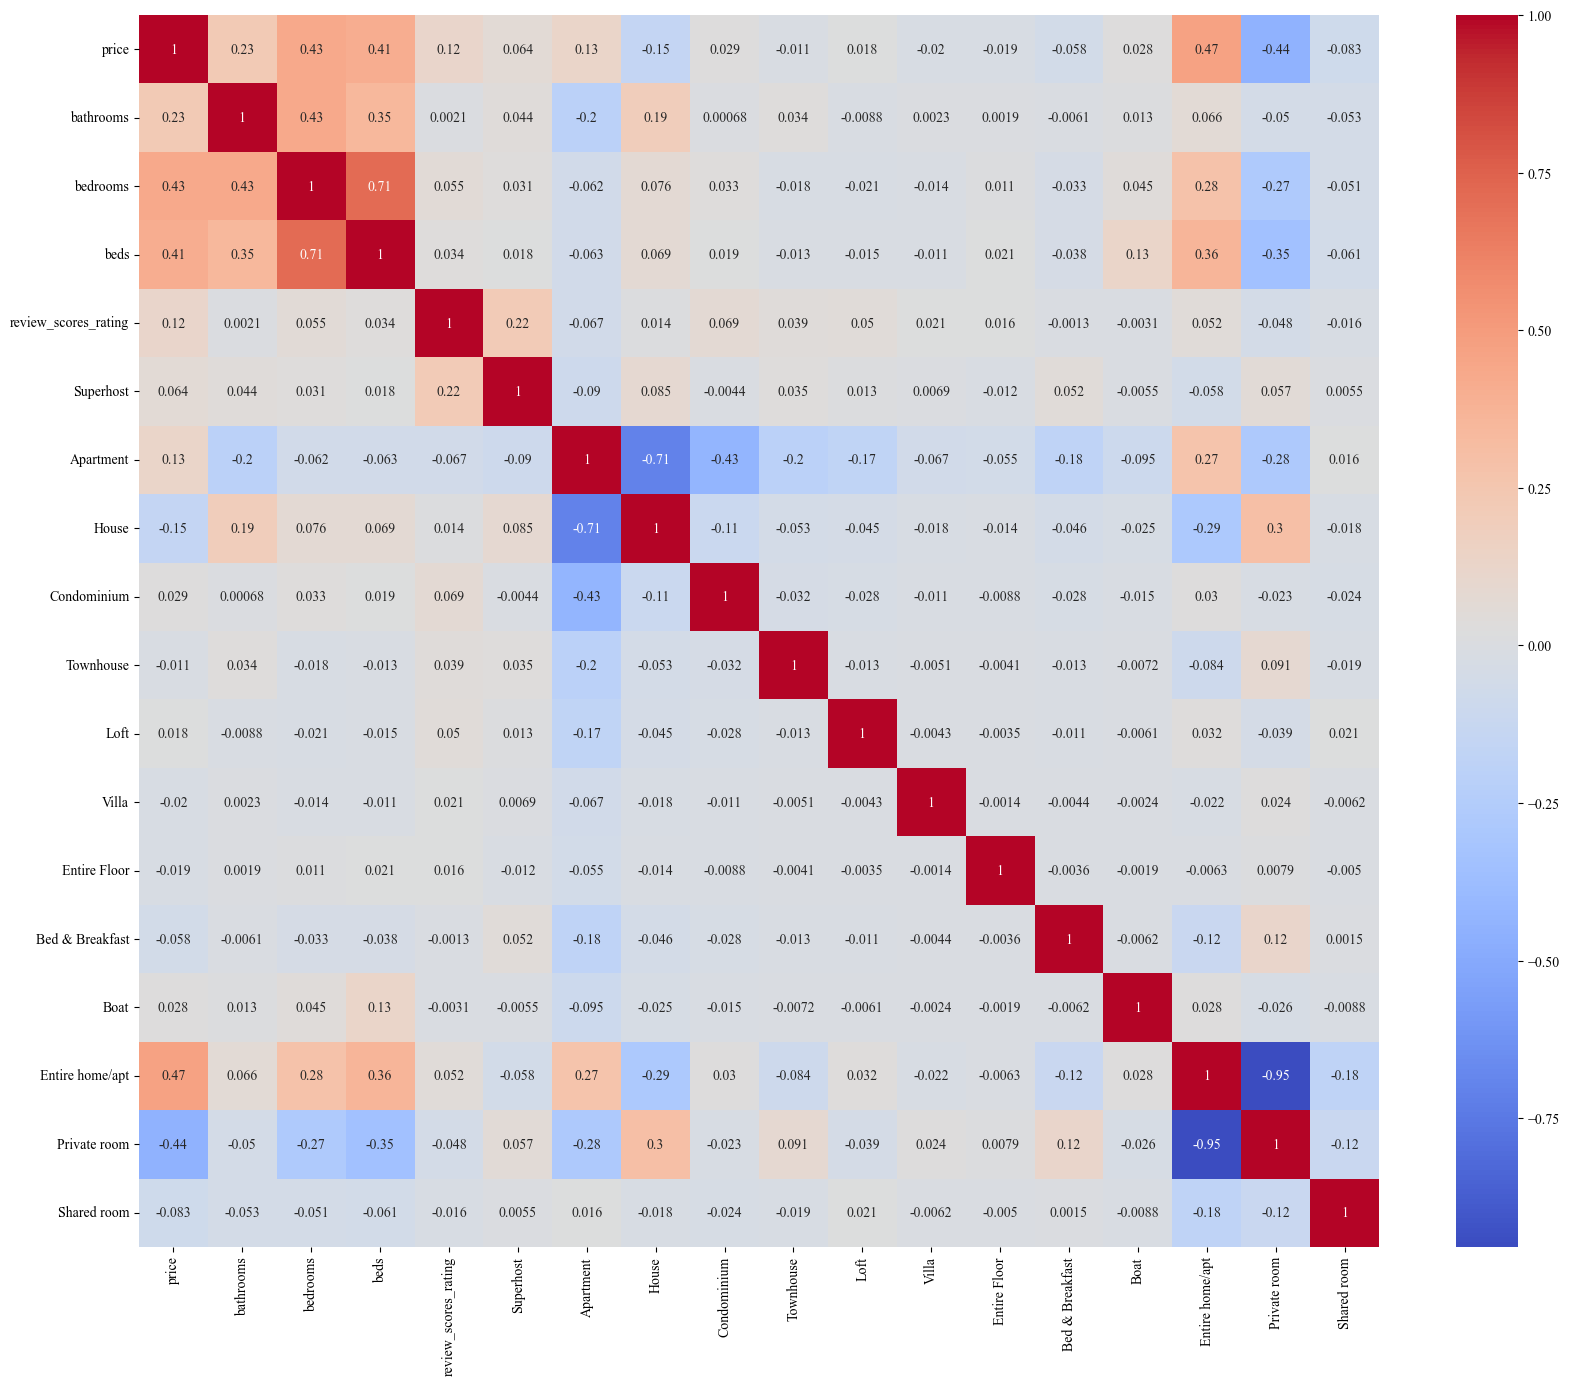

In [418]:
#Create a correlation matrix heatmap
#Variables are price, bathrooms, bedrooms, beds, review_scores_rating, Superhost, property type, and room type
#Exclude "Camper/RV" as not enough data points to be meaningful
#Exclude "Other" property type
#Guesthouse and Dorm are also dropped as they have very few data points

corr = CalLisCrime.drop_duplicates(subset=['id'])[["price", "bathrooms", "bedrooms", "beds", 
                  "review_scores_rating", "Superhost", "Apartment", 
                  "House", "Condominium", "Townhouse", 
                  "Loft", "Villa", "Entire Floor", 
                  "Bed & Breakfast", "Boat", 
                  "Entire home/apt", "Private room", "Shared room"]].corr()

#Configure figure and axes
fig, ax = plt.subplots(figsize=(20, 16))

#Create heatmap
sns.heatmap(corr, annot=True, cmap="coolwarm", ax=ax)

plt.show()

Major covariates of interest: bathrooms, bedrooms, beds, room type, superhost

## Pre-Treatment Balance Between Treatment and Control Listings

In [375]:
treatment = ["Back Bay", "Beacon Hill", "Fenway", "Downtown", "South End",
         "Chinatown", "North End", "West End", "Leather District", "Bay Village"]
control = ["South Boston", "South Boston Waterfront",
             "Allston", "Longwood Medical Area", "Mission Hill",
             "Roxbury", "Charlestown" "Brighton", "East Boston", "Hyde Park", "Jamaica Plain",
       "Roslindale", "Dorchester", "West Roxbury", "Mattapan"]

#Create a new column for beds per bedroom. If a listing has 0 bedrooms, set beds per bedroom to NaN
CalLisCrime["Beds per Bedroom"] = np.where(CalLisCrime["bedrooms"] == 0, \
      np.nan, CalLisCrime["beds"] / CalLisCrime["bedrooms"])

#Create dummy variables indicating if a listing is in a treatment or control neighbourhood
CalLisCrime["treatment"] = CalLisCrime["neighbourhood_cleansed"].isin(treatment).astype(int)
CalLisCrime["control"] = CalLisCrime["neighbourhood_cleansed"].isin(control).astype(int)

balance_frame = CalLisCrime.copy()

#Create a dataframe with only the columns needed for the balance test
balance_frame = balance_frame[["date", "bathrooms", "bedrooms", "beds",
                              "Superhost", "Entire home/apt", "control",
                              "Private room", "Shared room", 
                              "treatment", "Beds per Bedroom", "price"]]

#Restrict dataset to April 10th, 2017
balance_frame = balance_frame[balance_frame["date"] == "2017-04-10"]

count = balance_frame[["treatment", "control"]].sum().to_frame().T
count["Total"] = count["treatment"] + count["control"]
count.columns = ["Treatment", "Control", "Difference"]

#Calculate the mean of each column for treatment and control
balance_frame = balance_frame.groupby("treatment")[["price", "bathrooms", "bedrooms",
                                    "beds", "Beds per Bedroom", "Superhost",
                                    "Entire home/apt", "Private room", 
                                    "Shared room"]].mean().T.reset_index()

#Calculate the difference between treatment and control
balance_frame["difference"] = balance_frame[1] - balance_frame[0]

#Rename columns
balance_frame.columns = ["Variable", "Treatment", "Control", "Difference"]

#Set index to "Variable"
balance_frame.set_index("Variable", inplace=True)

#Put count row at the top
balance_frame = pd.concat([balance_frame, count])

#Rename all rows
balance_frame.index = ["Price", "Bathrooms", "Bedrooms", "Beds", "Beds per Bedroom",
                       "Superhost", "Entire home/apt", "Private room", "Shared room",
                       "N"]

#Create title and round numbers to 3 decimal places
balance_frame.style.set_caption("Table 7: Balance Test for Treatment and Control \
                              Neighbourhoods - Boston, MA: April 10th, 2017").format("{:.3f}")


,Treatment,Control,Difference
Price,143.070,251.245,108.174
Bathrooms,1.245,1.192,-0.052
Bedrooms,1.319,1.175,-0.144
Beds,1.637,1.573,-0.065
Beds per Bedroom,1.208,1.227,0.019
Superhost,0.131,0.091,-0.041
Entire home/apt,0.428,0.804,0.376
Private room,0.547,0.177,-0.370
Shared room,0.025,0.019,-0.006
N,1577.000,1713.000,3290.000


## Checking Parallel Trends

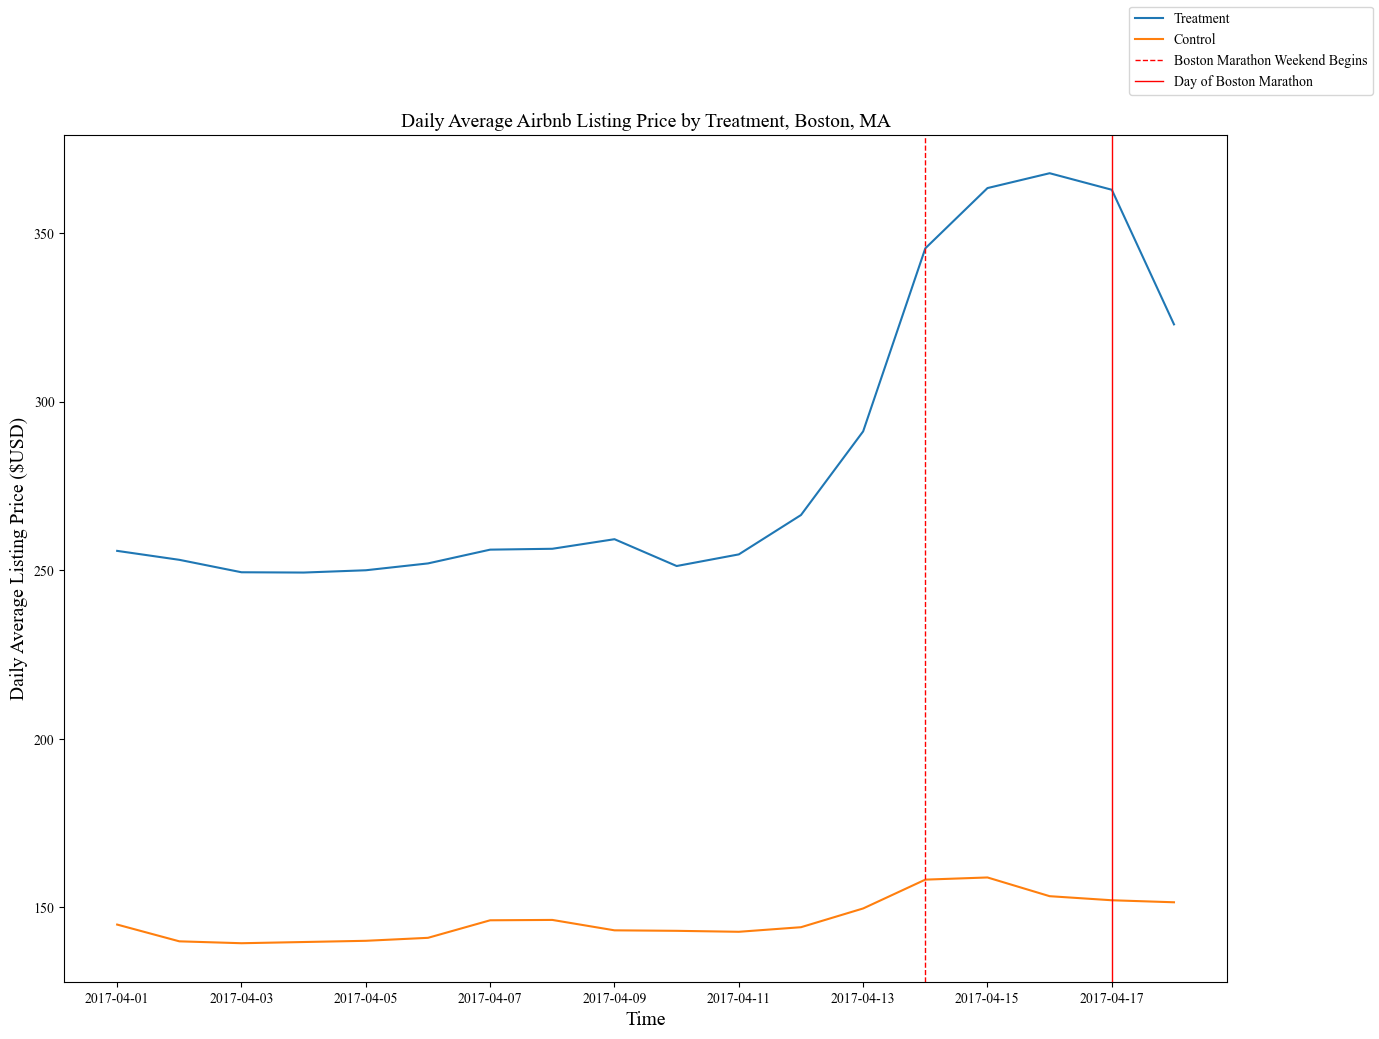

In [422]:
trends_frame = CalLisCrime.groupby(["treatment", "date"])["price"].mean().to_frame().reset_index()

trends_frame = trends_frame[(trends_frame["date"] >= "2017-04-01") & (trends_frame["date"] <= "2017-04-18")]

trends_frame_graph = trends_frame.groupby("treatment")

# Configure figure and axes
fig, ax = plt.subplots(figsize=(15, 11))

# Plot separate lines for treatment = 1 and treatment = 0
ax.plot(trends_frame_graph.get_group(1)["date"], trends_frame_graph.get_group(1)["price"], label="Treatment")
ax.plot(trends_frame_graph.get_group(0)["date"], trends_frame_graph.get_group(0)["price"], label="Control")

ax.set_title(
"Daily Average Airbnb Listing Price by Treatment, Boston, MA", 
fontsize=14)

ax.set_xlabel("Time", fontsize = 14)
ax.set_ylabel("Daily Average Listing Price ($USD)", fontsize = 14)

#Place 2 vertical lines for August 14th and August 17th
ax.axvline(x=pd.to_datetime("2017-04-14"), color="red", linestyle="--", linewidth=1, 
           label="Boston Marathon Weekend Begins")
ax.axvline(x=pd.to_datetime("2017-04-17"), color="red", linestyle="-", linewidth=1,
              label="Day of Boston Marathon")

#Place legend in upper right corner
fig.legend(loc="upper right")

plt.show()



## Two-Period Difference-in-Differences Regression

We estimate the following Difference-in-Differences (DiD) regression model to measure the effect of the Boston Marathon on Airbnb listing prices:

$$
\log(\text{Price}_{it}) = \beta_0 + \beta_1 \text{TreatmentListing}_{i} + \beta_2 \text{MarathonDate}_{t} + \beta_3 (\text{TreatmentListing}_{i} \times \text{MarathonDate}_{t}) + \beta_4 X_{it}' + \varepsilon_{it}
$$

Where:
- $ \log(\text{Price}_{it}) $ is the log of Airbnb listing price for listing $i$ on date $t$.
- $ \text{TreatmentListing}_{i} $ is an indicator variable for whether the listing is in a treatment neighbourhood.
- $ \text{MarathonDate}_{t} $ is a binary variable equal to 1 on April 17, 2017 (Boston Marathon date), and 0 otherwise.
- $ \text{TreatmentListing}_{i} \times \text{MarathonDate}_{t} $ is the interaction term, capturing the causal effect of the marathon on treatment listings.
- $ X_{it}' $ includes additional control variables for listing $i$ on date $t$, such as:
  - Superhost status
  - Property type (e.g., apartment, house, etc.)
  - Room type (e.g., entire home, private room, etc.)
- $ \varepsilon_{it} $ is the error term.


In [435]:
reg_frame1 = CalLisCrime.copy()

#Drop NaN id values
reg_frame1.dropna(subset=["id"], inplace=True)

#Filter to include only listings with a price
reg_frame1 = CalLisCrime[CalLisCrime["price"].notna()]

#Filter to only inlude April 10th to 17th, 2017
reg_frame1 = reg_frame1[(reg_frame1["date"] >= "2017-04-10") & (reg_frame1["date"] <= "2017-04-17")]

#Drop listings with Nan in Beds per Bedroom or bathrooms
reg_frame1 = reg_frame1[reg_frame1["bathrooms"].notna()]
reg_frame1 = reg_frame1[reg_frame1["Beds per Bedroom"].notna()]

#Create a dummy if listing is in the marathon period from April 14th to 17th
reg_frame1["Marathon Period"] = (reg_frame1["date"] >= "2017-04-14").astype(int)

#Create log price variable
reg_frame1["Log(Price)"] = np.log(reg_frame1["price"])

#Create interaction term between treatment and marathon date
reg_frame1["Treatment*Marathon Period"] = reg_frame1["treatment"] * \
                                       reg_frame1["Marathon Period"]

#Create a triple interaction with treatment, marathon date, and superhost
reg_frame1["Treatment*Marathon Period*Superhost"] = reg_frame1["treatment"]* \
    reg_frame1["Marathon Period"] * reg_frame1["Superhost"]


In [442]:
Y = reg_frame1["Log(Price)"]

X1 = reg_frame1[["treatment", "Marathon Period", "Treatment*Marathon Period"]]
X1 = sm.add_constant(X1)

X2 = reg_frame1[["treatment", "Marathon Period", "Treatment*Marathon Period", "Superhost"]]
X2 = sm.add_constant(X2)

#House is reference
X3 = reg_frame1[["treatment", "Marathon Period", "Treatment*Marathon Period", 
                "Superhost", "Beds per Bedroom"]]
X3 = sm.add_constant(X3)

X4 = reg_frame1[["treatment", "Marathon Period", "Treatment*Marathon Period", 
                "Superhost", "Beds per Bedroom", "bathrooms"]]
X4 = sm.add_constant(X4)

#Entire home/apt is reference
X5 = reg_frame1[["treatment", "Marathon Period", "Treatment*Marathon Period", 
                "Superhost", "Beds per Bedroom", "bathrooms", "Private room",
                "Shared room"]]
X5 = sm.add_constant(X5)

#Home is reference
X6 = reg_frame1[["treatment", "Marathon Period", "Treatment*Marathon Period",
                "Superhost", "Beds per Bedroom", "bathrooms", "Private room",
                "Shared room", 'Apartment', 'Bed & Breakfast', 'Boat', 
                'Condominium', 'Entire Floor', 
                'Loft', 'Other', 'Townhouse', 'Villa']]
X6 = sm.add_constant(X6)

X7 = reg_frame1[["treatment", "Marathon Period", "Treatment*Marathon Period",
                 "Treatment*Marathon Period*Superhost",
                "Superhost", "Beds per Bedroom", "bathrooms", "Private room",
                "Shared room", 'Apartment', 'Bed & Breakfast', 'Boat', 
                'Condominium', 'Entire Floor', 
                'Loft', 'Other', 'Townhouse', 'Villa']]
X7 = sm.add_constant(X7)

model1 = sm.OLS(Y, X1).fit(cov_type="cluster", cov_kwds={"groups": reg_frame1["id"]})
model2 = sm.OLS(Y, X2).fit(cov_type="cluster", cov_kwds={"groups": reg_frame1["id"]})
model3 = sm.OLS(Y, X3).fit(cov_type="cluster", cov_kwds={"groups": reg_frame1["id"]})
model4 = sm.OLS(Y, X4).fit(cov_type="cluster", cov_kwds={"groups": reg_frame1["id"]})
model5 = sm.OLS(Y, X5).fit(cov_type="cluster", cov_kwds={"groups": reg_frame1["id"]})
model6 = sm.OLS(Y, X6).fit(cov_type="cluster", cov_kwds={"groups": reg_frame1["id"]})
model7 = sm.OLS(Y, X7).fit(cov_type="cluster", cov_kwds={"groups": reg_frame1["id"]})

stargazer = Stargazer([model1, model2, model3, model4, model5, model6, model7])

stargazer.covariate_order(["treatment", "Marathon Period",
                            "Treatment*Marathon Period",
                            "Treatment*Marathon Period*Superhost",
                            "Superhost",
                            "Beds per Bedroom", "bathrooms", 
                            "const"])

#Rename regressors for table
stargazer.rename_covariates({
    "treatment": "Treatment Listing",
    "Marathon Period": "Boston Marathon Period",
    "Treatment*Marathon Period": "Treatment Listing X Boston Marathon Period",
    "Treatment*Marathon Period*Superhost": "Treatment Listing X Marathon Period X Superhost",
    "bathrooms": "Number of Bathrooms",
    "const": "Constant"
})

stargazer.add_line("Room Type Controls", 
                   ["No", "No", "No", "No", "Yes", "Yes", "Yes"])
stargazer.add_line("Property Type Controls", 
                   ["No", "No", "No", "No", "No", "Yes", "Yes"])

#Create a title
stargazer.title("Table 1: OLS Regression Results of Log Price on Treatment Listings \
and Boston Marathon Period")

#Create a note
stargazer.add_custom_notes(["Standard errors are robust. \
                            The dependent variable is the natural log of listing price. The sample \
                            includes listings with observations on April 10th and 17th, 2017. \
                            Listings are assigned to treatment based on their neighbourhood. \
                            Treatment neighbourhoods are Fenway, Back Bay, Beacon Hill, West \
                            End, North End, Downtown, Chinatown, and South End. Control \
                            neighbourhoods are Brighton, Allston, Longwood, Mission Hill, \
                            Roxbury, South Boston, South Boston Waterfront, East Boston, \
                            Charlestown, Dorchester, Jamaica Plain, Roslindale, and West Roxbury."])
                           

html_output = stargazer.render_html()

from IPython.display import display, HTML
display(HTML(html_output))

# Placebo Test

In [447]:
reg_frame2 = CalLisCrime.copy()

#Drop NaN id values
reg_frame2.dropna(subset=["id"], inplace=True)

#Filter to include only listings with a price
reg_frame2 = CalLisCrime[CalLisCrime["price"].notna()]

#Filter to only inlude April 3rd to 10th, 2017
reg_frame2 = reg_frame2[(reg_frame2["date"] >= "2017-04-03") & (reg_frame2["date"] <= "2017-04-10")]

#Drop listings with Nan in Beds per Bedroom or bathrooms
reg_frame2 = reg_frame2[reg_frame2["bathrooms"].notna()]
reg_frame2 = reg_frame2[reg_frame2["Beds per Bedroom"].notna()]

#Create a dummy if listing is on the day of the Boston Marathon
reg_frame2["Placebo Period"] = (reg_frame2["date"] >= "2017-04-07").astype(int)

#Create log price variable
reg_frame2["Log(Price)"] = np.log(reg_frame2["price"])

#Create interaction term between treatment and marathon date
reg_frame2["Treatment*Placebo Period"] = reg_frame2["treatment"] * \
                                       reg_frame2["Placebo Period"]


In [449]:
Y = reg_frame2["Log(Price)"]

X1 = reg_frame2[["treatment", "Placebo Period", "Treatment*Placebo Period"]]
X1 = sm.add_constant(X1)

X2 = reg_frame2[["treatment", "Placebo Period", "Treatment*Placebo Period", "Superhost"]]
X2 = sm.add_constant(X2)

#House is reference
X3 = reg_frame2[["treatment", "Placebo Period", "Treatment*Placebo Period", 
                "Superhost", "Beds per Bedroom"]]
X3 = sm.add_constant(X3)

#House is reference
#Entire home/apt is reference
X4 = reg_frame2[["treatment", "Placebo Period", "Treatment*Placebo Period", 
                "Superhost", "Beds per Bedroom", "bathrooms"]]
X4 = sm.add_constant(X4)

X5 = reg_frame2[["treatment", "Placebo Period", "Treatment*Placebo Period", 
                "Superhost", "Beds per Bedroom", "bathrooms", "Private room",
                "Shared room"]]
X5 = sm.add_constant(X5)

X6 = reg_frame2[["treatment", "Placebo Period", "Treatment*Placebo Period",
                "Superhost", "Beds per Bedroom", "bathrooms", "Private room",
                "Shared room", 'Apartment', 'Bed & Breakfast', 'Boat', 
                'Condominium', 'Entire Floor', 
                'Loft', 'Other', 'Townhouse', 'Villa']]
X6 = sm.add_constant(X6)

model1 = sm.OLS(Y, X1).fit(cov_type="cluster", cov_kwds={"groups": reg_frame2["id"]})
model2 = sm.OLS(Y, X2).fit(cov_type="cluster", cov_kwds={"groups": reg_frame2["id"]})
model3 = sm.OLS(Y, X3).fit(cov_type="cluster", cov_kwds={"groups": reg_frame2["id"]})
model4 = sm.OLS(Y, X4).fit(cov_type="cluster", cov_kwds={"groups": reg_frame2["id"]})
model5 = sm.OLS(Y, X5).fit(cov_type="cluster", cov_kwds={"groups": reg_frame2["id"]})
model6 = sm.OLS(Y, X6).fit(cov_type="cluster", cov_kwds={"groups": reg_frame2["id"]})

stargazer = Stargazer([model1, model2, model3, model4, model5, model6])

stargazer.add_line("Room Type Controls", 
                   ["No", "No", "No", "No", "Yes", "Yes"])
stargazer.add_line("Property Type Controls", 
                   ["No", "No", "No", "No", "No", "Yes"])

stargazer.covariate_order(["treatment", "Placebo Period",
                            "Treatment*Placebo Period",
                            "Superhost",
                            "Beds per Bedroom", "bathrooms", 
                            "const"])

#Rename regressors for table
stargazer.rename_covariates({
    "treatment": "Treatment Listing",
    "Placebo Period": "Placebo Period",
    "Treatment*Placebo Period": "Treatment Listing X Placebo Period",
    "bathrooms": "Number of Bathrooms",
    "const": "Constant"
})

#Create a title
stargazer.title("Table 1: OLS Regression Results of Log Price on Treatment Listings \
and Placebo Period")

#Create a note
stargazer.add_custom_notes(["Standard errors are robust. \
                            The dependent variable is the natural log of listing price. The sample \
                            includes listings with observations on April 10th and 17th, 2017. \
                            Listings are assigned to treatment based on their neighbourhood. \
                            Treatment neighbourhoods are Fenway, Back Bay, Beacon Hill, West \
                            End, North End, Downtown, Chinatown, and South End. Control \
                            neighbourhoods are Brighton, Allston, Longwood, Mission Hill, \
                            Roxbury, South Boston, South Boston Waterfront, East Boston, \
                            Charlestown, Dorchester, Jamaica Plain, Roslindale, and West Roxbury."])
                           

html_output = stargazer.render_html()

from IPython.display import display, HTML
display(HTML(html_output))

## Difference-in-Differences Regression with Panel Fixed Effects

The panel fixed effects Difference-in-Differences (DiD) model is specified as:

$$
\log(\text{Price}_{it}) = \alpha + \delta_{DiD} (\text{TreatmentListing}_i \times \text{MarathonPeriod}_t) + \sum_t \gamma_t Day_t + \sum_i \theta_i ListingFE_i + \varepsilon_{it}
$$

### **Where:**
- $ \log(\text{Price}_{it}) $ = Log of the Airbnb price for listing $ i $ at time $ t $.
- **$ TreatmentListing_i $** = 1 if listing is in the affected area (e.g., Boston), 0 otherwise.
- **$ MarathonPeriod_t $** = 1 if the observation is **after the Boston Marathon**, 0 if before.
- **$ TreatmentListing_i \times MarathonPeriod_t $** = The **Difference-in-Differences interaction term**, capturing the causal effect.
- **$ \sum_t \gamma_t Day_t $** = **Daily Fixed Effects**, controlling for shocks affecting all listings on the same day (e.g., demand trends, seasonality, other events).
- **$ \sum_i \theta_i ListingFE_i $** = **Listing Fixed Effects**, controlling for time-invariant listing characteristics (e.g., location, host reputation, property type).
- **$ \varepsilon_{it} $** = Error term.

In [ ]:
#Documentation: 
#https://bashtage.github.io/linearmodels/panel/panel/linearmodels.panel.model.PanelOLS.html
from linearmodels.panel import PanelOLS

panel_frame = CalLisCrime.copy()

#Filter to include only August 10th to 17th
panel_frame = panel_frame[(panel_frame["date"] >= "2017-04-10") & 
                          (panel_frame["date"] <= "2017-04-17")]

#Create dummy if listing falls in marathon period
#Marathon period falls between August 14th to 17th
panel_frame["MarathonPeriod"] = (panel_frame["date"] >= "2017-04-14").astype(int)

#Create log price variable
panel_frame["Log_Price"] = np.log(panel_frame["price"])

#Create interaction term between treatment and marathon date
panel_frame["Treatment_MarathonPeriod"] = panel_frame["treatment"] * \
                                       panel_frame["MarathonPeriod"]

#Create triple interaction term between treatment, marathon date, and superhost
panel_frame["Treatment_MarathonPeriod_Superhost"] = panel_frame["treatment"] * \
    panel_frame["MarathonPeriod"] * panel_frame["Superhost"]

#Create a time variable which indicates the number of days since the first date
panel_frame["time"] = (panel_frame["date"] - panel_frame["date"].min()).dt.days

#Create an interaction between time and treatment
#Allows for non parallel pre-trends
panel_frame["treatment_time"] = panel_frame["treatment"] * panel_frame["time"]

#Keep id as a column for clustering
panel_frame["id_col"] = panel_frame["id"]  

# Set index to id and date for PanelOLS model
panel_frame = panel_frame.set_index(['id', 'date'])

#Drop NaN values in Log_Price and Treatment_MarathonPeriod
panel_frame = panel_frame.dropna(subset=["Log_Price", "Treatment_MarathonPeriod"])

#Run PanelOLS model from a formula
#Entity Effects and Time Effects are defined by the index
#Entity Effects correspond to the id variable
#Time Effects correspond to the date variable
model1 = PanelOLS.from_formula(
    "Log_Price ~ Treatment_MarathonPeriod + EntityEffects",
    data=panel_frame
).fit(cov_type="clustered", clusters=panel_frame["id_col"])  

model2 = PanelOLS.from_formula(
    "Log_Price ~ Treatment_MarathonPeriod + TimeEffects",
    data=panel_frame
).fit(cov_type="clustered", clusters=panel_frame["id_col"])

model3 = PanelOLS.from_formula(
    "Log_Price ~ Treatment_MarathonPeriod + EntityEffects + TimeEffects",
    data=panel_frame
).fit(cov_type="clustered", clusters=panel_frame["id_col"])

model4 = PanelOLS.from_formula(
    "Log_Price ~ Treatment_MarathonPeriod + treatment_time + EntityEffects + TimeEffects",
    data=panel_frame
).fit(cov_type="clustered", clusters=panel_frame["id_col"])

model5 = PanelOLS.from_formula(
    "Log_Price ~ Treatment_MarathonPeriod + treatment_time + Treatment_MarathonPeriod_Superhost + EntityEffects + TimeEffects",
    data=panel_frame
).fit(cov_type="clustered", clusters=panel_frame["id_col"])

#Create table for model

stargazer = Stargazer([model1, model2, model3, model4, model5])

#Add row to table to indicate which effects are active in each column
stargazer.add_line("Listing Fixed Effects", 
                   ["Yes", "No", "Yes", "Yes", "Yes"])
stargazer.add_line("Time Fixed Effects", 
                   ["No", "Yes", "Yes", "Yes", "Yes"])

#Reorder rows
stargazer.covariate_order(["Treatment_MarathonPeriod", "treatment_time",
                            "Treatment_MarathonPeriod_Superhost"])

#Rename interaction term
stargazer.rename_covariates({"Treatment_MarathonPeriod": "Treatment Listing X Marathon Period",
                             "Treatment_MarathonPeriod_Superhost": "Treatment Listing X Marathon Period X Superhost",
                             "treatment_time": "Treatment Listing X Time"})

#Create a title
stargazer.title("")

#Create a note
stargazer.add_custom_notes([""])
                           
html_output = stargazer.render_html()

from IPython.display import display, HTML
display(HTML(html_output))

## Placebo Test

In [ ]:
panel_placebo = CalLisCrime.copy()

#Filter to include only August 3rd to 10th
panel_placebo = panel_placebo[(panel_placebo["date"] >= "2017-04-03") & 
                          (panel_placebo["date"] <= "2017-04-10")]

#Placebo period falls between August 7th to 10th
panel_placebo["PlaceboPeriod"] = (panel_placebo["date"] >= "2017-04-07").astype(int)

#Create log price variable
panel_placebo["Log_Price"] = np.log(panel_placebo["price"])

#Create interaction term between treatment and placebo period
panel_placebo["Treatment_PlaceboPeriod"] = panel_placebo["treatment"] * \
                                       panel_placebo["PlaceboPeriod"]

#Create a time variable which indicates the number of days since the first date
panel_placebo["time"] = (panel_placebo["date"] - panel_placebo["date"].min()).dt.days

#Create an interaction between time and treatment
panel_placebo["treatment_time"] = panel_placebo["treatment"] * panel_placebo["time"]

#Create a column for id for clustering
panel_placebo["id_col"] = panel_placebo["id"]

#Set index to id and date for PanelOLS model
panel_placebo = panel_placebo.set_index(['id', 'date'])

#Drop NaN values in Log_Price and Treatment_PlaceboPeriod
panel_placebo = panel_placebo.dropna(subset=["Log_Price", "Treatment_PlaceboPeriod"])

#Run PanelOLS model from a formula
#Entity Effects and Time Effects are defined by the index
#Entity Effects correspond to the id variable
#Time Effects correspond to the date variable
model1 = PanelOLS.from_formula(
    "Log_Price ~ Treatment_PlaceboPeriod + EntityEffects",
    data=panel_placebo
).fit(cov_type="clustered", clusters=panel_placebo["id_col"])

model2 = PanelOLS.from_formula(
    "Log_Price ~ Treatment_PlaceboPeriod + TimeEffects",
    data=panel_placebo
).fit(cov_type="clustered", clusters=panel_placebo["id_col"])

model3 = PanelOLS.from_formula(
    "Log_Price ~ Treatment_PlaceboPeriod + EntityEffects + TimeEffects",
    data=panel_placebo
).fit(cov_type="clustered", clusters=panel_placebo["id_col"])

model4 = PanelOLS.from_formula(
    "Log_Price ~ Treatment_PlaceboPeriod + treatment_time + EntityEffects + TimeEffects",
    data=panel_placebo
).fit(cov_type="clustered", clusters=panel_placebo["id_col"])

#Create table for model
stargazer = Stargazer([model1, model2, model3, model4])

#Add row to table to indicate which effects are active in each column
stargazer.add_line("Listing Fixed Effects", 
                   ["Yes", "No", "Yes", "Yes"])
stargazer.add_line("Time Fixed Effects", 
                   ["No", "Yes", "Yes", "Yes"])

#Rename interaction term
stargazer.rename_covariates({"Treatment_PlaceboPeriod": "Treatment Listing X Placebo Period",
                             "treatment_time": "Treatment Listing X Time"})

#Create a title
stargazer.title("")

#Create a note
stargazer.add_custom_notes([""])
                           
html_output = stargazer.render_html()

from IPython.display import display, HTML
display(HTML(html_output)) 

# 5. Conclusion

To conclude, my project shows that in 2017, the average Airbnb listing price in Boston, MA increases during the Boston Marathon. Furthermore, the effect of the marathon appears to be isolated to certain neighbourhoods near the marathon itself. This then supports my research design which assigns neighbourhoods into treatment and control groups. However, simply comparing neighbourhoods is not enough to estimate causality as neighbourhoods differ systematically. Thus, in future projects I will also utilize my controls to make like comparisons and estimate the causal effect of the 2017 Boston Marathon on local Airbnb listing prices.

# Data Sources

Boston Airbnb Open Data: https://www.kaggle.com/datasets/airbnb/boston

Crimes in Boston: https://www.kaggle.com/datasets/ankkur13/boston-crime-data


# Bibliography

Boston Athletic Association Communications Department. 2017. "2017 Boston Marathon Will Mean $192.2 Million For Greater Boston Economy." *Boston Athletic Association*, March 23. https://www.baa.org/2017-boston-marathon-will-mean-1922-million-greater-boston-economy.

Brady, James. 2017. “Boston Marathon 2017: Route information, course map, road closures and more.” *SB Nation*, April 17. https://www.sbnation.com/2017/4/17/15284838/2017-boston-marathon-route-map-traffic.

Cheung, Ka Shing, and Chung Yim Yiu. 2023. “The Paradox of Airbnb, Crime and House Prices: A Reconciliation.” *Tourism Economics: The Business and Finance of Tourism and Recreation* 29 (5): 1412–18. https://doi.org/10.1177/13548166221102808.

City of Boston. 2009. “Neighbourhoods.” Accessed February 4, 2025. https://www.cityofboston.gov/images_documents/Neighborhoods_tcm3-8205.pdf. 

Ert, Eyal, and Aliza Fleischer. 2019. “The Evolution of Trust in Airbnb: A Case of Home Rental.” *Annals of Tourism Research* 75: 279–87. https://doi.org/10.1016/j.annals.2019.01.004. 

Greenstone, Michael, and Justin Gallagher. 2008. “Does Hazardous Waste Matter? Evidence from the Housing Market and the Superfund Program.” *The Quarterly Journal of Economics* CXXIII (3): 951–1004. http://www.jstor.org/stable/25098922. 

Lawani, Abdelaziz, Michael R Reed, Tyler Mark, and Yuqing Zheng. 2019. “Reviews and Price on Online Platforms: Evidence from Sentiment Analysis of Airbnb Reviews in Boston.” *Regional Science and Urban Economics* 75: 22–34. https://doi.org/10.1016/j.regsciurbeco.2018.11.003.

Piga, Claudio, and Giuseppe Melis. 2021. “Identifying and Measuring the Impact of Cultural Events on Hotels’ Performance.” *International Journal of Contemporary Hospitality Management* 33 (4): 1194–1209. https://doi.org/10.1108/IJCHM-07-2020-0749. 
